# Dashboard credit scoring + veille technique

# __________________________________________________________________________________________

# *Projet 6 : Classifiez automatiquement des biens de consommation*

Nous sommes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.


Notre objectif était de réaliser une étude de faisabilité d'un moteur de classification automatique d’articles, en utilisant leur image et leur description sur le jeu de données fourni.

`Notre premier travail était d'analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes :`
* Un prétraitement des données texte et image,
* Une extraction de features,
* Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle,
* Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie,
* Une réalisation d’une mesure pour confirmer notre analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.

# __________________________________________________________________________________________

# Notebook 1

# **ETAPE 0** : Notebook de prétraitement de nos textes<a id="Notebook-de-prétraitement-de-nos-textes"></a>

# 1. Importation des Bibliothèques <a id="Importation-des-Bibliothèques"></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime
from zoneinfo import ZoneInfo
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA
from sklearn import manifold, cluster, metrics
import gensim
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import tensorflow_hub as hub
import tensorflow as tf
from transformers import AutoModel, BertTokenizerFast, BertModel

***

# 2. Importation des données <a id="Importation-des-données"></a>

* ### Chargement des données

In [12]:
# Chargement des données
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv') 

* ### Dimensions du dataset (nombre de lignes et de colonnes)

In [14]:
df.shape

(1050, 15)

Ce jeu de données contient 1050 lignes et 15 colonnes.

* ### Résumé des variables qualitatives 

In [17]:
df.describe(exclude=[np.number])

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   

                                       image is_FK_Advantage_product  \
count                                   1050                    1050   
unique                                  1050                       2   
top     55b85ea15a1536d46b7190ad6fff8ce7.jpg                   False   
freq                                       1                     993   

                                              description  \
count                                                1050   
unique                                               1050   
top     Key Features of Elegance Polyester Multicolor ...   
freq                                                    1   

             product_rating       overall_rating         brand  \
count                  1050                 1050           712   
unique                   27                   27           490   
top     No rating available  No rating available  PRINT SHAPES   
freq                    889                  889            11   

                                   product_specifications  
count                                                1049  
unique                                                984  
top     {"product_specification"=>[{"key"=>"Type", "va...  
freq                                                   22

* ### Résumé des variables quantitatives

In [19]:
df.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

* ### Types de données 

In [21]:
df.info()
pd.set_option('display.max_columns', None) # pour afficher toutes les colonnes 
pd.set_option('display.max_rows', 100) # pour afficher 100 lignes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Notre DataFrame contient :
* 1 colonne de type boléen
* 2 colonnes de type float
* 12 colonnes de type object.

memory usage: 116.0+ KB : Cela indique que le DataFrame utilise environ 116,0 Kilooctets (KB) de mémoire.

* ### Aperçu rapide des premières lignes du jeu de données 

In [24]:
# Affichage des premières lignes du DataFrame des commandes
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

* ### Nombre de valeurs uniques 

In [26]:
# Nombre de valeurs différentes par colonne
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

**Il y a :**
* un `uniq_id`,
* une `product_url`,
* un `product_name`,
* un `pid`,
* une `description`,
* et une `image`,

**différents pour chaque ligne, ce qui signifie que chaque produit est unique et possède ses propres identifiants, URL, nom, description, et image.**

* ### Identification des doublons 

In [29]:
# Vérification du nombre de doublons
nombre_doublons = df.duplicated().sum()
print(f"Le nombre total de doublons dans cette table est : {nombre_doublons}")

Le nombre total de doublons dans cette table est : 0


* ### Vérification des valeurs manquantes

In [31]:
print(df.isnull().sum())

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64


* ### Visualisation des valeurs manquantes <a id="Visualisation-des-Valeurs-manquantes"></a>

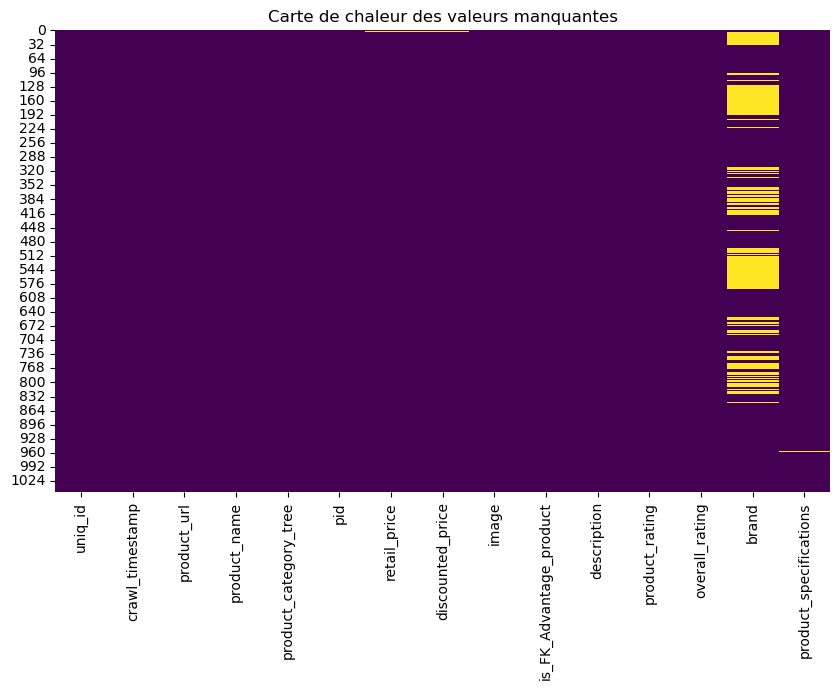

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Carte de chaleur des valeurs manquantes')
plt.show()

**Nous pouvons observer la colonne "brand" (marque) avec des lignes vides.**

***

# 3. Suppression des colonnes inutiles <a id="Suppression-des-colonnes-inutiles"></a>

* ### Colonne "crawl_timestamp"

In [38]:
# Conversion en format datetime
#df["crawl_timestamp"] = pd.to_datetime(df["crawl_timestamp"])

# Extraction d'informations utiles
#df["year"] = df["crawl_timestamp"].dt.year
#df["month"] = df["crawl_timestamp"].dt.month
#df["day"] = df["crawl_timestamp"].dt.day
#df["hour"] = df["crawl_timestamp"].dt.hour

# Affichage des premières lignes pour vérifier le résultat
#print(df[["crawl_timestamp", "year", "month", "day", "hour"]].head())

**Nous avons converti la colonne "crawl_timestamp" en format datetime et extrait les composantes utiles (année, mois, jour, heure), avant de la supprimer. Elle indique la date de récupération des données, ce qui n'est pas pertinent pour prédire la catégorie du produit.**

In [40]:
# Suppression de la colonne 'crawl_timestamp'
df.drop(columns=['crawl_timestamp'], inplace=True)

* ### Colonne "pid"

In [42]:
# Affichage des premières valeurs de la colonne 'pid'
premieres_valeurs_pid = df['pid'].head(5)
print(premieres_valeurs_pid)

# Suppression de la colonne 'pid' du DataFrame
df.drop(columns=['pid'], inplace=True)

0    CRNEG7BKMFFYHQ8Z
1    BTWEGFZHGBXPHZUH
2    BTWEG6SHXTDB2A2Y
3    BDSEJT9UQWHDUBH4
4    BDSEJTHNGWVGWWQU
Name: pid, dtype: object


**Colonne Complexe à comprendre : semble être un identifiant unique de produit, n'apporte pas d'information utile pour la classification.**

* ### Colonne "retail_price" et "discounted_price"

In [45]:
# Affichage des premières valeurs des colonnes 'retail_price' et 'discounted_price'
premieres_valeurs_prix = df[['retail_price', 'discounted_price']].head()
print(premieres_valeurs_prix)

# Suppression des colonnes 'retail_price' et 'discounted_price' du DataFrame
df.drop(columns=['retail_price', 'discounted_price'], inplace=True)

   retail_price  discounted_price
0        1899.0             899.0
1         600.0             449.0
2           NaN               NaN
3        2699.0            1299.0
4        2599.0             698.0


**Tarif standard et tarif promotionnel : Les prix peuvent varier selon les promotions et ne sont pas forcément discriminants pour la catégorie du produit.** 

* ### Colonne "is_FK_Advantage_product"

In [48]:
# Affichage des premières valeurs des colonnes 'is_FK_Advantage_product' 
premieres_valeurs_is_FK = df[['is_FK_Advantage_product']].head()
print(premieres_valeurs_is_FK)

# Suppression des colonnes 'is_FK_Advantage_product'
df.drop(columns=['is_FK_Advantage_product'], inplace=True)

   is_FK_Advantage_product
0                    False
1                    False
2                    False
3                    False
4                    False


**Indicateur binaire lié à un programme spécifique de la plateforme "Flipkart Advantage". Peu probable qu'il influence directement la catégorie produit.**

* ### Colonne "product_rating" et "overall_rating" (note globale)

In [51]:
# Affichage des comptes des valeurs de 'product_rating'
comptes_product_rating = df['product_rating'].value_counts().head()
print(comptes_product_rating)

# Affichage des comptes des valeurs de 'overall_rating'
comptes_overall_rating = df['overall_rating'].value_counts().head()
print(comptes_overall_rating)

# Filtrage des lignes où 'product_rating' est différent de 'overall_rating'
ratings_differents = df[df['product_rating'] != df['overall_rating']]
#print(ratings_differents)

# Suppression des colonnes 'product_rating' et 'overall_rating' du DataFrame
df.drop(columns=['product_rating', 'overall_rating'], inplace=True)

ratings_differents

product_rating
No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: count, dtype: int64
overall_rating
No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: count, dtype: int64


Empty DataFrame
Columns: [uniq_id, product_url, product_name, product_category_tree, image, description, product_rating, overall_rating, brand, product_specifications]
Index: []

**Ces colonnes reflètent l'opinion des utilisateurs et non les caractéristiques intrinsèques du produit. De plus, ces deux colonnes semblent similaires et fournissent peu d'informations.**

* ### Colonne brand (marque)

In [54]:
# Affichage des premières valeurs des colonnes 'brand'
premieres_valeurs_brand = df[['brand']].head()
print(premieres_valeurs_brand)

# Affichage des comptes des valeurs de la colonne 'brand', y compris les valeurs manquantes
comptes_marques = df['brand'].value_counts(dropna=False)
print(comptes_marques)

# Suppression de la colonne 'brand' du DataFrame
df.drop(columns=['brand'], inplace=True)

                   brand
0               Elegance
1               Sathiyas
2                Eurospa
3  SANTOSH ROYAL FASHION
4           Jaipur Print
brand
NaN                   338
Lapguard               11
PRINT SHAPES           11
Lal Haveli             10
Raymond                 8
                     ... 
Rute                    1
NAMS                    1
JewelKraft Designs      1
Budding Bees            1
Mee Mee                 1
Name: count, Length: 491, dtype: int64


**Colonne intéressante, mais avec beaucoup de valeurs manquantes, elle n'est donc pas utile. cela complique l'entraînement sans apporter une forte valeur discriminante.**

* ### Colonne image

In [57]:
# Affichage des premières valeurs des colonnes 'image'
premieres_valeurs_image = df[['image']].head(3)
print(premieres_valeurs_image)

                                  image
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg
1  7b72c92c2f6c40268628ec5f14c6d590.jpg
2  64d5d4a258243731dc7bbb1eef49ad74.jpg


* ### Colonne description

In [59]:
# Affichage des premières valeurs des colonnes 'description'
premieres_valeurs_description = df[['description']].head(3)
print(premieres_valeurs_description)

                                         description
0  Key Features of Elegance Polyester Multicolor ...
1  Specifications of Sathiyas Cotton Bath Towel (...
2  Key Features of Eurospa Cotton Terry Face Towe...


***

# 4. Nettoyage des catégories (product_category_tree) <a id="Nettoyage-des-catégories"></a>
La colonne **"product_category_tree"** est **la catégorie réelle du produit** (nous avons besoin de la nettoyer).

Ce champ est actuellement sous forme de liste JSON avec plusieurs niveaux hiérarchiques. Il faudra extraire la catégorie principale c-d la première catégorie affichée dans l’arborescence.

Exemple, l’arborescence de catégories est représentée par des niveaux hiérarchiques séparés par `>>` : `["['Computers & Accessories >> Laptops']"]` : dans cet exemple, la catégorie principale est `"Computers & Accessories"`. C’est le premier niveau de l’arborescence — la "grande famille" de produits.
On ignore les sous-catégories comme "Laptops".

Parce qu’il peut y avoir des centaines de sous-catégories, très précises, mais nous on veut regrouper les produits dans de grandes catégories homogènes pour simplifier les analyses.

In [62]:
import numpy as np

# Extraction de la catégorie principale
def clean_category_tree(categories):
    try:
        categories = eval(categories)  # Conversion de la chaîne en liste
        main_category = categories[0].split(">>")[0]  # Extraction de la catégorie principale
        return main_category.strip()
    except:
        return np.nan

df['main_category'] = df['product_category_tree'].apply(clean_category_tree)

# Suppression de la colonne originale devenue inutile
df.drop(columns=['product_category_tree'], inplace=True)

# Aperçu du résultat
print(df[['main_category']].head())

     main_category
0  Home Furnishing
1        Baby Care
2        Baby Care
3  Home Furnishing
4  Home Furnishing


**Nous avons :**
* converti la chaîne JSON en liste Python (eval).
* Extrait uniquement la catégorie principale.
* Supprimé "product_category_tree" après extraction.

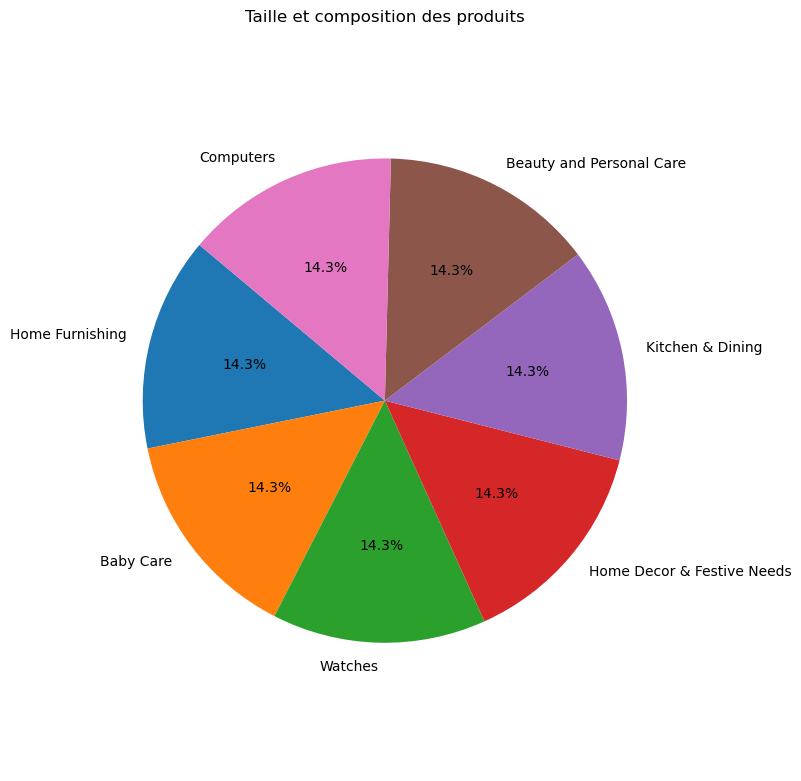

In [64]:
import matplotlib.pyplot as plt

# Récupèration de catégories principales
taille_categories = df['main_category'].value_counts(dropna=False).head(10)

# Palette de couleurs (10 couleurs distinctes)
colors = plt.cm.tab10.colors  # palette colorée et lisible

# Camembert
plt.figure(figsize=(8,8))
plt.pie(taille_categories.values, 
        labels=taille_categories.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=colors)


plt.title("Taille et composition des produits")
plt.axis('equal')  # pour que le camembert soit bien rond
plt.tight_layout()
plt.show()

* ## **Attribution de codes numériques aux catégories uniques.**

In [66]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['main_category_encoded'] = le.fit_transform(df['main_category'])

In [67]:
le.classes_

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

* Les chiffres générés par LabelEncoder() sont simplement des codes numériques attribués aux catégories uniques.
* Ils servent à convertir des valeurs catégoriques en valeurs numériques utilisables par les algorithmes de Machine Learning.
* LabelEncoder() trie les catégories par ordre alphabétique et leur attribue un numéro croissant.

In [69]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6])

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [70]:
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                              product_specifications    main_category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

   main_category_encoded  
0                      4  
1                      0  
2                      0  
3                      4  
4                      4

***

# 5. Nettoyage des données textuelles ("product_name" et "description") <a id="Nettoyage-des-données-textuelles"></a>
La colonne **"description"** contient **le contenu textuel principal pour la classification.**

**"product_name"** peut être combiné avec description pour enrichir l’analyse.

* Nettoyage : suppression des stopwords, ponctuation, caractères spéciaux, mise en minuscules.
* Tokenisation et normalisation (lemmatisation/stemming).

## 5.1. Fonctions de traitement <a id="Fonctions-de-traitement"></a>
Chaque fonction sera responsable d'une étape spécifique (nettoyage, tokenisation, lemmatisation, etc.).

In [75]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

# Télécharger les ressources nécessaires de NLTK
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Fonction pour obtenir le bon tag grammatical pour la lemmatisation
def get_wordnet_pos(treebank_tag):
    """Convertit les tags de pos_tag() en tags utilisables par WordNetLemmatizer."""
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # Par défaut, on considère que c'est un nom

# Fonction de nettoyage
def clean_text(text):
    """Nettoie et normalise un texte."""
    text = text.lower()  # Conversion en minuscules
    text = re.sub(r'\d+', '', text)  # Suppression des chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Suppression de la ponctuation
    return text

# Fonction de tokenisation
def tokenize_text(text):
    """Tokenisation du texte."""
    return word_tokenize(text)

# Fonction de suppression des stopwords
def remove_stopwords(tokens):
    """Supprime les stopwords."""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Fonction de lemmatisation
def lemmatize_tokens(tokens):
    """Lemmatisation des tokens."""
    lemmatizer = WordNetLemmatizer()
    tagged_tokens = pos_tag(tokens)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]

In [76]:
# Fonction de stemming (appliqué uniquement dans le test)
def apply_stemming(tokens):
    """Applique le stemming."""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

## 5.2. Application du nettoyage sur le dataframe <a id="Application-du-nettoyage-sur-le-dataframe"></a>

In [78]:
# Fonction complète de nettoyage à appliquer sur le dataframe
def process_text(text):
    text_cleaned = clean_text(text)
    tokens = tokenize_text(text_cleaned)
    tokens_no_stopwords = remove_stopwords(tokens)
    tokens_lemmatized = lemmatize_tokens(tokens_no_stopwords)
    return " ".join(tokens_lemmatized)

# Fusion des colonnes product_name et description
df['cleaned_text'] = df['product_name'].astype(str) + " " + df['description'].astype(str)

# Application de la fonction de nettoyage
df['cleaned_text'] = df['cleaned_text'].apply(process_text)

# Affichage du résultat
print(df[['product_name', 'description', 'cleaned_text']].head())

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                        cleaned_text  
0  elegance polyester multicolor abstract eyelet ...  
1  sathiyas cotton bath towel specification sathi...  
2  eurospa cotton terry face towel set key featur...  
3  santosh royal fashion cotton print king size d...  
4  jaipur print cotton floral king size double be..

**Nous avons :**
* converti le texte en minuscules.
* Supprimé les chiffres et ponctuation.
* Tokenisé et enlevé les stopwords.
* Appliqué la lemmatisation, *en spécifiant la catégorie grammaticale des mots. Par défaut, `WordNetLemmatizer` ne lemmatise que les noms (nouns), et pour d'autres parties du discours comme les verbes ou les adjectifs, il peut ne pas donner les résultats attendus. Il faut utiliser les tags grammaticaux (comme NN pour les noms, VB pour les verbes) pour spécifier à WordNetLemmatizer comment traiter chaque mot.*

* Stocké le texte propre dans cleaned_text.

**1. La tokenisation** est le processus de décomposition d'une phrase ou d'un texte en unités plus petites (mots individuels), appelés **tokens**. Cela permet de manipuler plus facilement chaque mot séparément. 

Ces unités peuvent être des mots, des phrases ou même des caractères individuels, en fonction de l'objectif de l'analyse. La tokenisation est une étape fondamentale dans le traitement automatique du langage naturel (NLP), car elle permet de préparer le texte brut pour une analyse plus approfondie.


**2. Les stopwords (ou "mots vides" en français)** sont des mots très fréquents mais peu informatifs (ex. "the", "is", "and", "in"). Ils sont généralement filtrés et supprimés lors du traitement du langage naturel (NLP), pour réduire le bruit et améliorer l’analyse du texte. 

Ces mots n'apportent souvent pas de valeur significative pour l'analyse textuelle, car ils apparaissent fréquemment et n'aident pas à distinguer un texte d'un autre.


**3. Le lemmatizer (ou "lemmatisation" en français)** est un processus en traitement du langage naturel (NLP) qui consiste à réduire les mots à leur forme canonique ou de base, appelée "lemme". Par exemple, dans une phrase comme "Les chats mangeaient des poissons", la lemmatisation transformerait "chats" en "chat", "mangeaient" en "manger", et "poissons" en "poisson". Contrairement au stemming, qui coupe simplement les suffixes pour obtenir la racine du mot, la lemmatisation prend en compte le contexte et la signification du mot pour le ramener à sa forme de base (il garde un mot existant).


**4. Le stemming** est un processus en traitement du langage naturel (NLP) qui consiste à réduire les mots à leur racine ou base commune (appelée "stem"). L'objectif du stemming est de regrouper différentes formes d'un mot pour qu'elles soient traitées de manière identique. Par exemple, les mots "running", "runner", "ran", et "runs" peuvent être réduits à la même racine "run".

Le stemming réduit un mot à sa racine en supprimant les suffixes, mais sans garantir un mot valide (méthode rapide mais parfois trop agressive).

***

# 6. Encodage des textes en vecteurs numériques (BoW / TF-IDF) <a id="Encodage-des-textes-en-vecteurs-numériques"></a>
Il s'agit de transformer le texte en vecteurs exploitables pour la classification. 

Autrement dit, créer des représentations numériques des textes pour les algorithmes de machine learning.

### 6.1. `Bag of Words (BoW)` et `VTF-IDF (Term Frequency - Inverse Document Frequency)` <a id="Bag-of-Words-et-VTF-IDF"></a>

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def create_bow_features(texts, min_df=3, max_df=0.8):
    """Crée une représentation Bag-of-Words (BoW) et retourne aussi le vectorizer."""
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    bow_matrix = vectorizer.fit_transform(texts)
    return bow_matrix, vectorizer


def create_tfidf_features(texts, min_df=3, max_df=0.8):
    """Crée une représentation TF-IDF et retourne aussi le vectorizer."""
    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    return tfidf_matrix, tfidf_vectorizer

In [85]:
# Application de la fonction Bag-of-Words (BoW)
#bow_matrix = create_bow_features(df['cleaned_text'])

# Application de la fonction TF-IDF
#tfidf_matrix = create_tfidf_features(df['cleaned_text'])

* CountVectorizer() : Crée un modèle Bag-of-Words en comptant la fréquence des mots.
* TfidfVectorizer() : Calcule le TF-IDF pour pondérer les mots en fonction de leur importance.
* min_df=3, max_df=0.8 : Ignore les mots très rares ou trop fréquents.

***

# 7. Test sur une phrase pour illustrer la bonne réalisation des 5 étapes de prétraitement <a id="Test-sur-une-phrase-pour-illustrer-la-bonne-réalisation-des-5-étapes-de prétraitement"></a>

In [89]:
# Phrase de test
test_sentence = "Running faster than the previous records is very challenging!"

# Nettoyage et traitement sur la phrase
cleaned_sentence = clean_text(test_sentence)
tokens = tokenize_text(cleaned_sentence)
tokens_no_stopwords = remove_stopwords(tokens)
lemmatized_sentence = " ".join(lemmatize_tokens(tokens_no_stopwords))

# Affichage des résultats intermédiaires
print("\n=== Phrase originale ===")
print(test_sentence)

print("\n=== Après nettoyage ===")
print(cleaned_sentence)

print("\n=== Après tokenisation ===")
print(tokens)

print("\n=== Après suppression des stopwords ===")
print(" ".join(tokens_no_stopwords))

print("\n=== Après lemmatisation ===")
print(lemmatized_sentence)

# Test du stemming uniquement pour la phrase
stemmed_tokens = apply_stemming(tokens_no_stopwords)
stemmed_sentence = " ".join(stemmed_tokens)

print("\n=== Après application du stemming (test uniquement) ===")
print(stemmed_sentence)

# Création des représentations BoW et TF-IDF avec des paramètres adaptés au test
bow_matrix, vectorizer = create_bow_features([cleaned_sentence, stemmed_sentence], min_df=1, max_df=1.0)
tfidf_matrix, tfidf_vectorizer = create_tfidf_features([cleaned_sentence, stemmed_sentence], min_df=1, max_df=1.0)

print("\n=== Matrice BoW ===")
print(bow_matrix.toarray())

print("\n=== Matrice TF-IDF ===")
print(tfidf_matrix.toarray())


=== Phrase originale ===
Running faster than the previous records is very challenging!

=== Après nettoyage ===
running faster than the previous records is very challenging

=== Après tokenisation ===
['running', 'faster', 'than', 'the', 'previous', 'records', 'is', 'very', 'challenging']

=== Après suppression des stopwords ===
running faster previous records challenging

=== Après lemmatisation ===
run faster previous record challenge

=== Après application du stemming (test uniquement) ===
run faster previou record challeng

=== Matrice BoW ===
[[0 1 1 1 0 1 0 1 0 1 1 1 1]
 [1 0 1 0 1 0 1 0 1 0 0 0 0]]

=== Matrice TF-IDF ===
[[0.         0.34287126 0.24395573 0.34287126 0.         0.34287126
  0.         0.34287126 0.         0.34287126 0.34287126 0.34287126
  0.34287126]
 [0.47107781 0.         0.33517574 0.         0.47107781 0.
  0.47107781 0.         0.47107781 0.         0.         0.
  0.        ]]


* Affichage du texte nettoyé AVANT tokenisation.
* Affichage de la tokenisation avant la lemmatisation.
* Lemmatisation appliquée sur les tokens, puis affichée.
* Maintien du stemming uniquement pour le test.
* Transformation BoW et TF-IDF avec le texte lemmatisé et stemmé.

***

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniq_id                 1050 non-null   object
 1   product_url             1050 non-null   object
 2   product_name            1050 non-null   object
 3   image                   1050 non-null   object
 4   description             1050 non-null   object
 5   product_specifications  1049 non-null   object
 6   main_category           1050 non-null   object
 7   main_category_encoded   1050 non-null   int32 
 8   cleaned_text            1050 non-null   object
dtypes: int32(1), object(8)
memory usage: 69.9+ KB


* ## **EXPORT**

In [94]:
df.to_csv("data_Final_P6.csv", index=False)

# __________________________________________________________________________________________

# Notebook 2

# 1. Importation des Bibliothèques <a id="Importation-des-Bibliothèques"></a>

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime
from zoneinfo import ZoneInfo
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA
from sklearn import manifold, cluster, metrics
import gensim
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import tensorflow_hub as hub
import tensorflow as tf
from transformers import AutoModel, BertTokenizerFast, BertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

import random
import os
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2
import tqdm
import time

# 2. Importation du Fichier néttoyé <a id="Importation-du-Fichier-néttoyé"></a>

In [100]:
# Chargement des données
df = pd.read_csv("data_Final_P6.csv")

# Copie intacte pour le traitement d’images uniquement (mission 2)
df_images = df.copy()


# Affichage du nombre de case
print(f"Nombre total de case est : {len(df)}")

# Affichage des premières lignes du DataFrame
df.head()

Nombre total de case est : 1050


uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                              product_specifications    main_category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

   main_category_encoded                                       cleaned_text  
0                      4  elegance polyester multicolor abstract eyelet ...  
1                      0  sathiyas cotton bath towel specification sathi...  
2                      0  eurospa cotton terry face towel set key featur...  
3                      4  santosh royal fashion cotton print king size d...  
4                      4  jaipur print cotton floral king size double be...

# 2. Définition de fonctions <a id="Définition-de-fonctions"></a>

* **Fonction de réduction de dimensionnalité avec PCA :** utile pour réduire la dimension des données avant d'appliquer t-SNE ou K-Means

In [103]:
def reduce_dimensionality_pca(data, num_components):
    """
    Réduit la dimensionnalité des données en utilisant l'analyse en composantes principales (PCA).

    Paramètres:
    data (DataFrame): Les données à réduire.
    num_components (int): Le nombre de composantes principales à conserver.

    Retourne:
    ndarray: Les données transformées avec les composantes principales.
    """
    # Initialisation de PCA avec le nombre de composantes principales
    pca = PCA(n_components=num_components)
    
    # Application de PCA sur les données
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

***

* **Fonction de réduction de dimensionnalité TruncatedSVD, qui est une méthode alternative au PCA :** TruncatedSVD est préféré dans les tâches de réduction de dimensionnalité pour des données textuelles, où les données sont généralement représentées sous forme de matrices creuses. TruncatedSVD est plus adapté que PCA sur des matrices creuses car il n'a pas besoin que les données soient centrées.

In [106]:
def reduce_dimensionality_svd(sparse_matrix, n_components=100):
    """
    Réduit la dimensionnalité des données en utilisant TruncatedSVD (une méthode de décomposition matricielle).

    Paramètres:
    sparse_matrix (sparse matrix): La matrice creuse à réduire.
    n_components (int): Le nombre de composantes principales à conserver. Par défaut, 100.

    Retourne:
    ndarray: La matrice transformée avec les composantes principales réduites.
    """
    # Cette fonction utilise TruncatedSVD comme alternative à PCA pour réduire la dimensionnalité.
    # TruncatedSVD est particulièrement efficace pour les matrices creuses (sparse matrices), 
    # comme celles issues de la vectorisation de texte (ex: CountVectorizer ou TfidfVectorizer).
    
    svd = TruncatedSVD(n_components=n_components, random_state=42)

    # Application de TruncatedSVD sur la matrice creuse
    reduced_data = svd.fit_transform(sparse_matrix)
    
    return reduced_data

***

* **Fonction de réduction de dimensionnalité avec t-SNE :** applique t-SNE pour réduire les dimensions à 2D, ce qui permet de visualiser facilement les clusters après un clustering.

In [109]:
def reduce_dimensionality_tsne(data):
    """
    Réduit la dimensionnalité des données en utilisant t-SNE pour visualiser les clusters en 2D.

    Paramètres:
    data (DataFrame): Les données à réduire.

    Retourne:
    ndarray: Les données transformées avec t-SNE en 2D.
    """
    # Initialisation de t-SNE avec les paramètres spécifiés
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
    
    # Application de t-SNE sur les données
    tsne_result = tsne.fit_transform(data)
    
    return tsne_result

***

* **Fonction pour appliquer UMAP (Uniform Manifold Approximation and Projection),** qui est une alternative rapide et efficace à t-SNE pour la réduction de dimensionnalité et la visualisation.
UMAP est souvent plus rapide, plus robuste, et préserve mieux la structure globale des données que t-SNE. Il est donc recommandé pour l'analyse exploratoire et la visualisation des données en 2D.

In [112]:
def reduce_dimensionality_umap(data, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean'):
    """
    Réduit la dimensionnalité des données en utilisant UMAP.

    Paramètres:
    - data (array-like ou DataFrame): Les données à réduire.
    - n_components (int): Le nombre de dimensions finales (par défaut, 2 pour la visualisation).
    - n_neighbors (int): Contrôle la balance entre structure locale et globale (par défaut, 15).
    - min_dist (float): Distance minimale entre les points dans l'espace réduit (contrôle la dispersion).
    - metric (str): Mesure de distance (ex: 'euclidean', 'cosine', etc.).

    Retourne:
    - ndarray: Les données transformées avec UMAP.
    """
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, 
                         min_dist=min_dist, metric=metric, random_state=42)
    
    reduced_data = reducer.fit_transform(data)
    
    return reduced_data

***

* **Fonction de visualisation t-SNE avec les vraies classes :** permet de visualiser les données réduites en 2D par t-SNE, en utilisant les vraies classes comme couleurs.

In [115]:
def plot_tsne_clusters(tsne_data, categories):
    """
    Affiche un graphique 2D des clusters t-SNE avec les vraies classes.

    Paramètres:
    - tsne_data (ndarray): Données transformées par t-SNE (shape: [n_samples, 2]).
    - categories (array-like): Liste des vraies classes associées aux points.

    Retourne:
    - None (Affiche le graphique)
    """
    # Création du DataFrame
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = categories  # Utilisation explicite de la colonne de classe
    
    # Création du scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', 
        palette=sns.color_palette('tab10', n_colors=len(set(categories))),
        s=50, alpha=0.6, data=tsne_df
    )

    # Ajout des titres et labels
    plt.title('t-SNE selon les vraies classes', fontsize=16, fontweight='bold')
    plt.xlabel('Dimension 1 (t-SNE)', fontsize=14)
    plt.ylabel('Dimension 2 (t-SNE)', fontsize=14)
    plt.legend(title="Catégories", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

***

* **Fonction de clustering avec KMeans sur les données t-SNE :** applique K-Means sur des données réduites avec t-SNE et affiche les clusters trouvés. Ensuite, il évalue la correspondance entre les clusters et les vraies catégories avec l'Adjusted Rand Index (ARI).

In [118]:
def plot_kmeans_clusters(tsne_data, df, n_clusters=7):
    """
    Applique K-Means sur les données t-SNE et affiche un graphique des clusters.

    Paramètres:
    - tsne_data (ndarray): Données transformées par t-SNE (shape: [n_samples, 2]).
    - df (DataFrame): DataFrame contenant la colonne `main_category` pour l'ARI.
    - n_clusters (int): Nombre de clusters pour K-Means (par défaut 7).

    Retourne:
    - None (Affiche le graphique et imprime l'ARI)
    """
    # Création du DataFrame à partir des résultats t-SNE
    tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = df['main_category'].values

    # Vérification que n_clusters ne dépasse pas le nombre de classes uniques
    n_clusters = min(n_clusters, df['main_category'].nunique())

    # Application de K-Means sur les données t-SNE
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
    kmeans.fit(tsne_data)
    tsne_df['cluster'] = kmeans.labels_

    # Création du scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster', 
        palette=sns.color_palette('tab10', n_colors=n_clusters),
        s=50, alpha=0.6, data=tsne_df
    )

    # Ajout des titres et labels
    plt.title('t-SNE selon les clusters K-Means', fontsize=16, fontweight='bold')
    plt.xlabel('Dimension 1 (t-SNE)', fontsize=14)
    plt.ylabel('Dimension 2 (t-SNE)', fontsize=14)
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

    # Calcul et affichage de l'ARI
    ari = round(metrics.adjusted_rand_score(df['main_category'], kmeans.labels_), 2)
    print(f"Adjusted Rand Index (ARI) : {ari}")

***

* **Fonction qui affiche les graphiques 2D des clusters t-SNE réels et des clusters KMeans, tout en générant une matrice de confusion pour évaluer la qualité du clustering :**
***    
* Affichage des vraies catégories après réduction dimensionnelle avec t-SNE
    * On transforme les données en 2D à l’aide de t-SNE.
    * On crée un scatter plot des points colorés selon leur catégorie réelle (main_category).
***
* Application de K-Means sur les données t-SNE et visualisation des clusters
    * On applique K-Means avec n_clusters=7 sur les résultats t-SNE.
    * On affiche un scatter plot des points colorés selon leur cluster K-Means.
***
* Création et affichage d’une matrice de confusion entre les catégories réelles et les clusters K-Means
    * On tente de faire correspondre chaque cluster K-Means à une vraie catégorie.
    * On affiche une matrice de confusion pour évaluer la correspondance entre les groupes trouvés et les vraies classes.

In [121]:
def plot_tsne_and_kmeans_clusters(tsne_data):
    
    """
    Affiche des graphiques 2D des clusters t-SNE réels et KMeans, et crée une matrice de confusion.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """
    # Création d'un DataFrame à partir des résultats t-SNE
    df_tsne = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    df_tsne['class'] = df['main_category']

    # Définition des catégories pour la légende
    categories = df['main_category'].unique()
    category_palette = sns.color_palette('tab10', len(categories))

    # Agrandissement de la figure
    plt.figure(figsize=(26, 8))

    # Affichage des vraies classes
    plt.subplot(131)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=category_palette, s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les vraies classes', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Catégorie', prop={'size': 10})

    # Clustering avec K-Means
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    df_tsne['cluster'] = kmeans.labels_

    # Affichage des clusters K-Means
    plt.subplot(132)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les clusters K-Means', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Clusters', prop={'size': 10})

    # Matrice de confusion
    labels = df['main_category'].astype(str)  
    kmeans_labels = kmeans.labels_.astype(str) 

    # Création d'un dictionnaire pour relier chaque label KMeans à la catégorie réelle
    label_to_cluster = {i: label for i, label in enumerate(categories)}

    # Remappage des labels KMeans aux catégories réelles
    mapped_kmeans_labels = [label_to_cluster[int(cluster)] for cluster in kmeans_labels]

    # Calcul de la matrice de confusion
    conf_mat = metrics.confusion_matrix(labels, mapped_kmeans_labels)
    df_cm = pd.DataFrame(conf_mat, index=categories, columns=[f'Cluster {i}' for i in range(7)])

    # Affichage de la matrice de confusion
    plt.subplot(133)
    plt.title('Matrice de confusion', size=20, fontweight='bold')
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
    # Inclinaison des étiquettes de l'axe X et Y
    plt.xticks(rotation=45, ha='right')  # Inclinaison des labels de l'axe X
    plt.yticks(rotation=45, va='top')  # Inclinaison des labels de l'axe Y
    plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
    plt.ylabel('Catégories', fontsize=18, fontweight='bold')

    # Ajustement de l'espacement entre les sous-graphes pour éviter qu'ils ne se chevauchent
    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Augmentation de l'espacement horizontal et vertical
    
    plt.show()

    
    # Affichage de l'ARI
    ari = round(metrics.adjusted_rand_score(labels, kmeans.labels_), 3)
    print(f"L'indice de Rand ajusté (ARI) est de {ari}.")

* **Fonction qui utilise CountVectorizer de scikit-learn pour transformer une collection de textes en une matrice BoW.**
    * min_df et max_df sont des paramètres pour filtrer les mots qui apparaissent trop rarement ou trop fréquemment dans le corpus.
    * min_df définit le seuil minimal de fréquence d'apparition d'un mot pour qu'il soit pris en compte.
    * max_df définit le seuil maximal de fréquence d'apparition d'un mot pour qu'il soit pris en compte.
    * Elle renvoie une matrice sparse où chaque ligne représente un document, et chaque colonne représente un mot unique du vocabulaire, avec des valeurs indiquant la fréquence de chaque mot dans chaque document.

* **Bag-of-Words (BoW) compte combien de fois chaque mot apparaît.**

In [123]:
from sklearn.feature_extraction.text import CountVectorizer

def create_bow_features(texts, min_df=3, max_df=0.8):
    """Crée une représentation Bag-of-Words (BoW) et retourne aussi le vectorizer."""
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
    bow_matrix = vectorizer.fit_transform(texts)
    return bow_matrix, vectorizer

* **Fonction qui utilise TfidfVectorizer pour créer une matrice basée sur la pondération TF-IDF des mots dans les textes.**
    * Le fonctionnement est similaire à CountVectorizer, mais au lieu de simplement compter les occurrences de mots, TF-IDF ajuste la fréquence des mots en fonction de leur fréquence dans l'ensemble du corpus.
    * Cela donne plus d'importance aux mots rares et spécifiques à certains documents, et moins aux mots fréquents.
* **TF-IDF (Term Frequency - Inverse Document Frequency) mesure l’importance d’un mot dans un document par rapport à l’ensemble du corpus.**

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

def create_tfidf_features(texts, min_df=3, max_df=0.8):
    """Crée une représentation TF-IDF et retourne aussi le vectorizer."""
    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    return tfidf_matrix, tfidf_vectorizer

Le vectorizer, que ce soit un CountVectorizer (pour BoW) ou un TfidfVectorizer (pour TF-IDF), est un objet de scikit-learn qui permet de convertir du texte brut en vecteurs numériques que les algorithmes de Machine Learning peuvent utiliser.

* **Il apprend le vocabulaire du corpus :** Quand on fait .fit() ou .fit_transform(texts), il repère quels mots existent dans tous les textes et leur fréquence.

* **Il transforme chaque texte en vecteur :** Chaque texte est représenté comme un vecteur de longueur égale au nombre de mots du vocabulaire, où chaque case du vecteur correspond à un mot.

# __________________________________________________________________________________________

# **ETAPE 1 :** Classification en utilisant des méthodes NLP basiques <a id="Classification-en-utilisant-des-méthodes-NLP-basiques"></a>

        Méthode	             Type de 	               Captation             Sparsité	               Utilisation typique
                             représentation               du contexte	
    **********************************************************************************************************************************
    
    Bag-of-Words (BoW)	  Matrice de comptage       Aucun contexte	    Très sparse 	       Modèles simples (SVM,                                     
                              (mots × documents)	                           (beaucoup de 0)                 Naïve Bayes)
***
    TF-IDF	                 Matrice pondérée 	    Aucun contexte	    Toujours sparse	       Recherche d'information,                                                         
                            par importance des mots                                                            similarité
***    
    Word2Vec (embeddings)    Vecteurs denses de mots	    Oui                  Dense	                  NLP avancé,   
                                                       (relations entre mots)	                    clustering, classification
***    
    BERT, USE (embeddings)	 Vecteurs de phrases/	     Contexte riche 	         Dense	                  NLP avancé,                                                           
                                  documents               (sémantique)                                   compréhension du texte


# 1. Méthode Bag-of-words <a id="Méthode-Bag-of-words"></a>

Une approche **Bag-of-words (BoW)** est une méthode couramment utilisée en traitement du langage naturel (NLP) pour représenter du texte sous une forme numérique compréhensible par les algorithmes d'apprentissage automatique. Dans une approche BoW, un texte (document) est représenté par un vecteur de taille fixe, où chaque dimension du vecteur correspond à un mot du vocabulaire total extrait de l'ensemble des documents.

**Principe :**
* **Bag of Words** est une méthode qui représente un texte sous forme d’un vecteur basé sur la fréquence d’apparition des mots.
* On crée un vocabulaire contenant tous les mots du corpus.
* Chaque document est représenté par un vecteur, où chaque mot est remplacé par son nombre d’occurrences.
* L’ordre des mots n’est pas pris en compte.
* Le `CountVectorizer` transforme les textes en une matrice où chaque colonne représente un mot du vocabulaire et chaque ligne représente un document avec le compte de la fréquence d'apparition des mots dans ce document.

## 1.1. Extraction des features avec Bag-of-Words (BoW) <a id="Extraction-des-features-avec-Bag-of-Words-(BoW)"></a>
* Vectorisation via CountVectorizer

In [133]:
# Création du vecteur bag of words. Le but est de transformer chaque mot du texte en une valeur numérique.
#vectorizer = CountVectorizer().fit(df['cleaned_text']) 

# Transformation du texte en une matrice sparse
#bow_sparse_matrix = vectorizer.transform(df['cleaned_text'])

#bow_sparse_matrix

* CountVectorizer() sans paramètres : Il prend tous les mots sans restrictions (à part les stopwords par défaut si définis).
* Résultat : Matrice 1050x4944 : 4 944 mots uniques dans notre corpus.

**OU**

* **Code avec la fonction create_bow_features :** 
* Le premier code utilise directement `CountVectorizer()` pour d'abord apprendre un vocabulaire à partir de df['cleaned_text'] avec la méthode fit(), puis on utilise transform() pour convertir le texte en une matrice sparse. Cela produit une représentation BoW des textes.
* Le code avec `create_bow_features` : on appelle la fonction create_bow_features, qui utilise CountVectorizer en interne. La différence est que cette fonction encapsule l'ensemble du processus (apprentissage du vocabulaire et transformation du texte) en une seule étape.

Les deux produiront une matrice sparse représentant les textes sous forme de Bag-of-Words.

In [137]:
# Application de la fonction Bag-of-Words (BoW)
bow_sparse_matrix, vectorizer = create_bow_features(df['cleaned_text'])

bow_sparse_matrix

<1050x1405 sparse matrix of type '<class 'numpy.int64'>'
	with 29287 stored elements in Compressed Sparse Row format>

* Avec min_df=3 et max_df=0.8 :
    * min_df=3 : Ignore les mots qui apparaissent dans moins de 3 documents (élimine les mots rares).
    * max_df=0.8 : Ignore les mots qui apparaissent dans plus de 80% des documents (élimine les mots trop fréquents, comme "le", "et", etc.).

* Résultat : Matrice 1050x1405 : Seulement 1 405 mots uniques sont conservés.

Les matrices sparse (ou creuses) sont des matrices où la majorité des éléments sont égaux à zéro. Dans le contexte de la vectorisation du texte (comme ici avec BoW), une matrice sparse est très utilisée, car la plupart des mots dans un vocabulaire ne sont présents que dans un petit sous-ensemble des documents. 

**Leur utilité :**

* **Efficacité mémoire :**

Une matrice BoW classique peut être énorme si le vocabulaire est large. Par exemple, dans un corpus avec des millions de documents, le vocabulaire peut contenir des centaines de milliers de mots, mais chaque document ne contiendra que quelques centaines de mots. Cela entraîne une majorité de zéros dans la matrice. En utilisant des matrices sparse, seuls les éléments non nuls (les mots présents dans un document donné) sont stockés en mémoire, ce qui permet d'économiser beaucoup d'espace mémoire.

* **Calcul plus rapide :**

Lors du calcul de transformations ou d'algorithmes, les matrices creuses permettent de mieux gérer les calculs, car les opérations peuvent être effectuées uniquement sur les éléments non nuls, rendant le processus plus rapide.

* **Adapté au machine learning :**

Beaucoup d'algorithmes de machine learning, comme la régression, la classification, ou les réseaux de neurones, peuvent bénéficier de matrices creuses car elles sont plus légères et permettent un traitement plus rapide des données.

**En résumé, la matrice sparse est utilisée dans des contextes comme la vectorisation de texte (par exemple, avec CountVectorizer) pour réduire l'empreinte mémoire et accélérer les calculs.**

## 1.2. Affichage des mots les plus fréquents et illustration linguistique

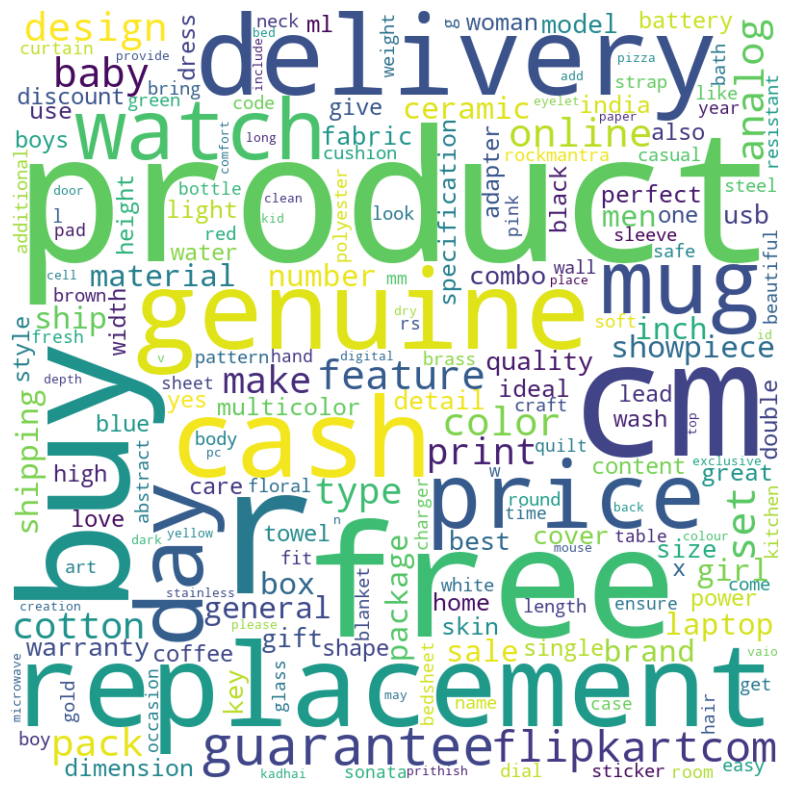


=== Mots les plus fréquents avec leur fréquence ===
product: 863
r: 845
cm: 672
free: 616
buy: 584
replacement: 568
delivery: 567
genuine: 564
cash: 564
price: 559
day: 555
mug: 525
watch: 506
guarantee: 473
flipkartcom: 472
set: 439
baby: 414
feature: 407
online: 396
design: 388
analog: 382
color: 377
pack: 351
cotton: 341
make: 338
type: 324
print: 318
showpiece: 312
material: 307
box: 305


In [141]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import nltk
import pandas as pd

# Initialisation du générateur de nuage de mots avec les paramètres souhaités
wordcloud = WordCloud(
    width=800, 
    height=800, 
    max_font_size=200, 
    min_font_size=10,
    background_color='white', 
    contour_width=0.1
)

# Combinaison des mots de la colonne 'cleaned_text' en une seule chaîne
mots_combines = ' '.join(df['cleaned_text'])

# Génération de la distribution de fréquence des mots
frequence_mots = nltk.FreqDist(mots_combines.split())

# Génération du nuage de mots à partir des fréquences des mots
wordcloud.generate_from_frequencies(frequence_mots)

# Affichage du nuage de mots
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Affichage des fréquences des 30 mots les plus fréquents dans la console
print("\n=== Mots les plus fréquents avec leur fréquence ===")
for word, freq in sorted(frequence_mots.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(f"{word}: {freq}")

## 1.3. Réduction dimensionnelle avec TruncatedSVD & Visualisation avec t-SNE + Clustering K-Means

**Pourquoi TruncatedSVD et non PCA?**
* PCA repose sur la décomposition de la matrice de covariance ou la SVD (Singular Value Decomposition) pour réduire la dimensionnalité.
    * Problème : Calculer la covariance sur une matrice sparse est inefficace en termes de mémoire et de temps de calcul, car cela densifie la matrice et la rend difficile à manipuler.

* Les matrices sparse contiennent beaucoup de zéros (ex. Bag-of-Words, TF-IDF).
    * PCA ne traite pas bien ces zéros, car il cherche à maximiser la variance, et une majorité de valeurs nulles réduit la variance informative.

* PCA ne conserve pas la structure éparse des données
    * Lorsque PCA est appliqué, les nouvelles dimensions résultantes sont généralement denses.
    * Cela signifie que même si l'entrée était sparse, la sortie devient une matrice dense, consommant beaucoup plus de mémoire.
***
* **Le TruncatedSVD** (Singular Value Decomposition tronquée) est une technique de réduction de dimensionnalité utilisée principalement pour les matrices creuses (sparse matrices). Il qui fonctionne bien sur les matrices sparse. Il est particulièrement utile dans le traitement du langage naturel et l'analyse de texte lorsque les données sont représentées sous forme de grandes matrices creuses, comme celles générées par des techniques de bag-of-words ou de TF-IDF.
    * Il évite de calculer la matrice de covariance complète.
    * Il conserve le format sparse pendant les calculs.
    * Il est utilisé dans LSA (Latent Semantic Analysis) pour la réduction de dimension des textes.

In [144]:
# Réduction dimensionnelle avec TruncatedSVD (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(bow_sparse_matrix)

reduced_data

array([[ 6.38605467e+00, -9.22198158e-01, -3.74434707e+00, ...,
         5.24753851e-17, -4.51028104e-17,  3.46944695e-17],
       [ 3.74158229e+00, -1.31671610e+00, -2.69239649e+00, ...,
        -9.06393016e-17,  2.34187669e-17,  3.46944695e-18],
       [ 8.26452496e+00, -3.18001351e+00, -4.01088304e+00, ...,
        -1.76941795e-16, -9.62771529e-17,  7.28583860e-17],
       ...,
       [ 1.29796803e+00, -6.30550072e-01,  1.91191807e+00, ...,
        -3.85888871e-17,  3.65406530e-18, -3.67037186e-17],
       [ 1.41679912e+00, -6.96593591e-01,  1.89930000e+00, ...,
        -2.77555756e-17, -1.04083409e-17, -6.93889390e-17],
       [ 1.32519561e+00, -6.60663130e-01,  1.90816805e+00, ...,
        -4.85722573e-17, -1.21430643e-17, -4.16333634e-17]])

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


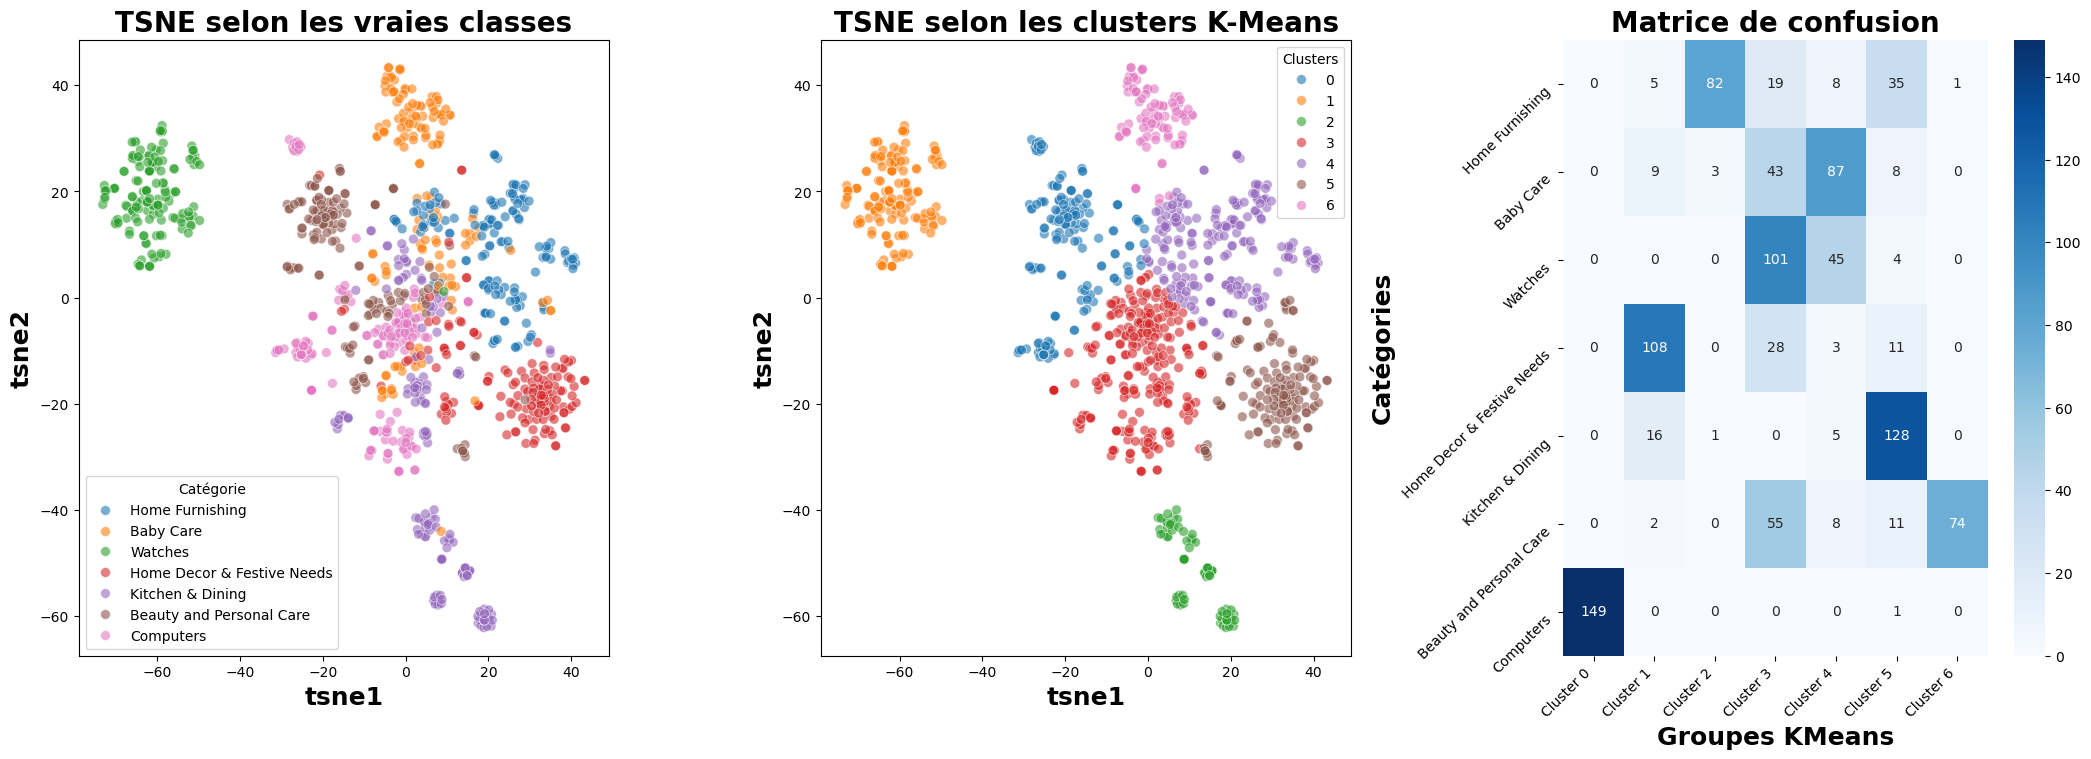

L'indice de Rand ajusté (ARI) est de 0.451.


In [145]:
# Réduction de la dimensionnalité
tsne_data = reduce_dimensionality_tsne(reduced_data)

# Appel de la fonction pour afficher les graphiques et les clusters
plot_tsne_and_kmeans_clusters(tsne_data)

***

# 2. Méthode TF-IDF (Term Frequency - Inverse Document Frequency) <a id="Méthode-TF-IDF-(Term Frequency-Inverse-Document-Frequency)"></a>
**TF-IDF (Term Frequency-Inverse Document Frequency)** est une technique d'évaluation de l'importance d'un mot dans un document par rapport à un corpus de documents. Contrairement au simple comptage des mots (CountVectorizer), TF-IDF prend en compte non seulement la fréquence d'un mot dans un document (TF), mais aussi la fréquence inverse du mot dans l'ensemble du corpus (IDF), ce qui permet de réduire l'importance des mots courants et de mettre en avant les mots plus significatifs pour chaque document.

* Meilleur pour la classification de texte et la recherche d’information.
* Idéal si on veut éviter d’être biaisé par les mots courants.




**Principe : `TF-IDF` améliore BoW en pondérant chaque mot selon :**
* Sa fréquence dans un document (TF - Term Frequency).
* Son importance dans l’ensemble du corpus (IDF - Inverse Document Frequency).
* La formule de TF-IDF est :

                  TF-IDF=TF×IDF, Avec :
        TF (Term Frequency) : fréquence d’un mot dans un document.
        IDF (Inverse Document Frequency) : pénalise les mots trop courants dans tous les documents.

Par exemple, si le mot "chat" apparaît 10 fois dans un document mais est rare dans le corpus global, il aura un score TF-IDF élevé.
En revanche, un mot comme "le" (qui apparaît partout) aura un score plus faible.

## 2.1. Extraction des features avec TF-IDF 
* Vectorisation via TfidfVectorizer

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialisation du vecteur TF-IDF
#tfidf_vectorizer = TfidfVectorizer().fit(df['cleaned_text'])

# Transformation du texte en une matrice sparse TF-IDF
#tfidf_sparse_matrix = tfidf_vectorizer.transform(df['cleaned_text'])

#tfidf_sparse_matrix

**OU**

In [151]:
# Application de la fonction TF-IDF
tfidf_sparse_matrix, tfidf_vectorizer = create_tfidf_features(df['cleaned_text'])

tfidf_sparse_matrix

<1050x1405 sparse matrix of type '<class 'numpy.float64'>'
	with 29287 stored elements in Compressed Sparse Row format>

## 2.2. Vérification de la distribution TF-IDF

* #### **Créer un vectorizer TEMPORAIRE uniquement pour extraire les mots**

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Création d'un vectorizer temporaire pour récupérer les mots
temp_vectorizer = TfidfVectorizer(min_df=3, max_df=0.8)
temp_vectorizer.fit(df['cleaned_text'])  # On ne transforme pas, juste le fit()

# Extraction de la liste des mots
word_list_tfidf = temp_vectorizer.get_feature_names_out()

* #### **Générer et afficher le nuage de mots avec les scores TF-IDF**

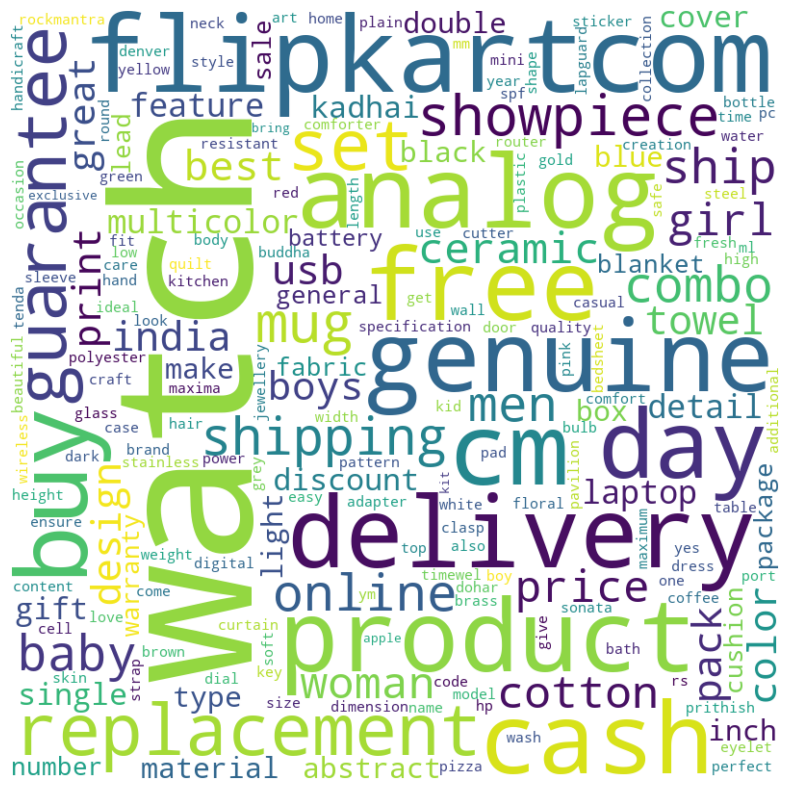


=== Mots avec les scores TF-IDF les plus élevés ===
watch: 0.0457
flipkartcom: 0.0420
cm: 0.0392
analog: 0.0392
product: 0.0387
cash: 0.0374
genuine: 0.0374
delivery: 0.0374
free: 0.0373
buy: 0.0371
day: 0.0346
replacement: 0.0346
set: 0.0339
guarantee: 0.0338
showpiece: 0.0307
mug: 0.0299
shipping: 0.0286
online: 0.0281
men: 0.0264
combo: 0.0261
baby: 0.0258
ship: 0.0248
cotton: 0.0217
girl: 0.0208
woman: 0.0208
price: 0.0204
ceramic: 0.0193
best: 0.0180
design: 0.0169
india: 0.0167


In [156]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Extraction des scores moyens par mot
word_tfidf_scores = np.array(tfidf_sparse_matrix.mean(axis=0)).flatten()

# Création d'un dictionnaire {mot: score TF-IDF moyen}
tfidf_dict = dict(zip(word_list_tfidf, word_tfidf_scores))

# Génération du nuage de mots
wordcloud = WordCloud(
    width=800, 
    height=800, 
    max_font_size=200, 
    min_font_size=10,
    background_color='white'
).generate_from_frequencies(tfidf_dict)

# Affichage du nuage de mots
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Affichage des 30 mots avec les scores TF-IDF les plus élevés
print("\n=== Mots avec les scores TF-IDF les plus élevés ===")
for word, score in sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(f"{word}: {score:.4f}")

## 2.3. Réduction dimensionnelle avec TruncatedSVD & Visualisation avec t-SNE + Clustering K-Means

In [158]:
# Réduction dimensionnelle avec TruncatedSVD (PCA n'étant pas adapté aux matrices sparse)
svd_model = TruncatedSVD(n_components=1000, random_state=42)
reduced_data = svd_model.fit_transform(tfidf_sparse_matrix)

reduced_data

array([[ 6.09515407e-02, -1.44227019e-01,  6.92129365e-02, ...,
         3.41523684e-18,  1.35525272e-19, -7.26415456e-18],
       [ 1.07252591e-01, -1.37970749e-01,  7.08673817e-02, ...,
         1.19262239e-18, -3.68628739e-18, -4.11996826e-18],
       [ 1.19531967e-01, -1.77500800e-01,  3.17272593e-02, ...,
        -2.16840434e-18,  4.55364912e-18,  2.38524478e-18],
       ...,
       [ 1.07079960e-01, -7.63050442e-02, -4.72598368e-02, ...,
         1.54906479e-18, -4.96436842e-18, -1.12020668e-18],
       [ 9.90630174e-02, -7.69709264e-02, -4.25428411e-02, ...,
         1.08420217e-18, -5.20417043e-18,  0.00000000e+00],
       [ 1.39414189e-01, -1.00813064e-01, -6.22571875e-02, ...,
         1.73472348e-18, -6.31547765e-18, -6.93889390e-18]])

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


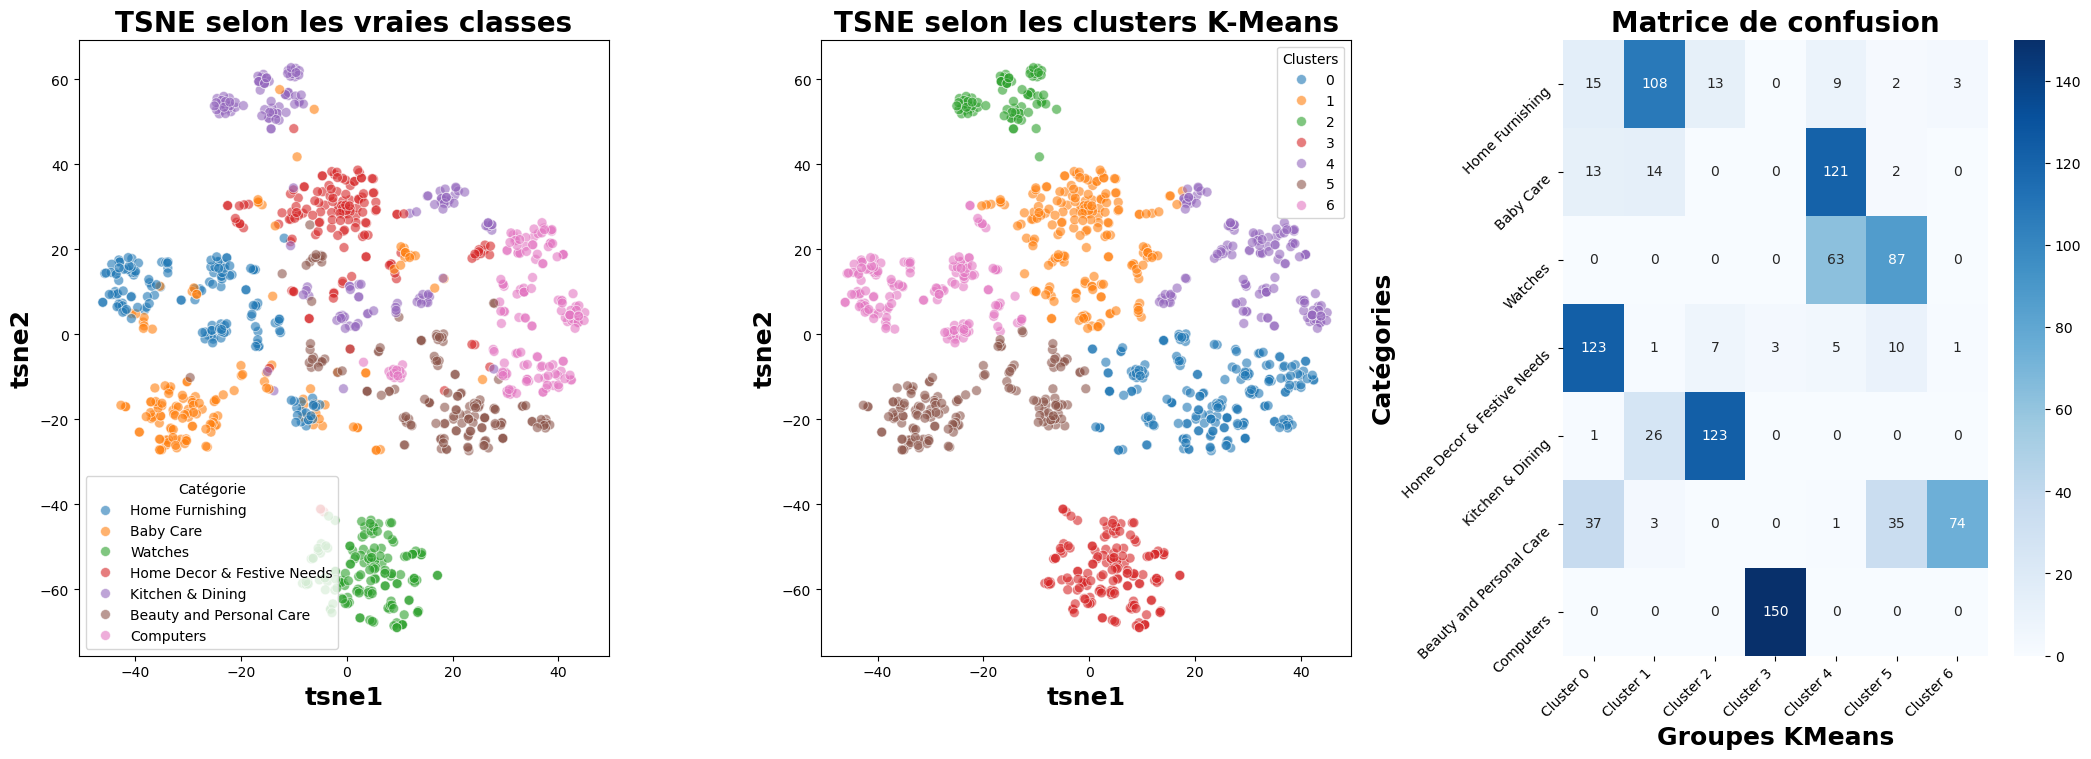

L'indice de Rand ajusté (ARI) est de 0.551.


In [159]:
# Réduction de la dimensionnalité
tsne_data = reduce_dimensionality_tsne(reduced_data)

# Appel de la fonction pour afficher les graphiques et les clusters
plot_tsne_and_kmeans_clusters(tsne_data)

# __________________________________________________________________________________________

# **ETAPE 2 :** Classification en utilisant des techniques NLP plus avancées <a id="Classification-en-utilisant-des-méthodes-NLP-plus-avancées"></a>

# 1. Méthode Word2Vec <a id="Méthode-Word2Vec"></a>

L'approche **Word2Vec** est une méthode avancée pour représenter des mots sous forme de vecteurs continus dans un espace vectoriel de dimension réduite. Contrairement à l'approche Bag-of-words qui compte simplement les occurrences de mots, Word2Vec capture les relations sémantiques entre les mots en les représentant sous forme de vecteurs de taille fixe, où des mots similaires ont des vecteurs similaires.

## 1.1. Extraction des features avec Word2Vec 
* Tokenisation des descriptions
* Entraînement d’un modèle Word2Vec
* Moyennage des vecteurs de mots pour obtenir une représentation par produit

In [164]:
# Obtenir le nombre de cœurs du processeur
num_cores = multiprocessing.cpu_count()

# Affichage du nombre de cœurs
print(f"Nombre de cœurs disponibles : {num_cores}")

Nombre de cœurs disponibles : 16


In [165]:
from gensim.models import FastText

# Tokenisation de la colonne 'cleaned_text'
df['Word2Vec_tokenized_description'] = df['cleaned_text'].apply(gensim.utils.simple_preprocess)

# Entraînement de Word2Vec avec CBOW (sg=0) et Skip-gram (sg=1)
word2vec_cbow = Word2Vec(sentences=df['Word2Vec_tokenized_description'], vector_size=100, window=5, min_count=2, sg=0, workers=num_cores)
word2vec_skipgram = Word2Vec(sentences=df['Word2Vec_tokenized_description'], vector_size=100, window=5, min_count=2, sg=1, workers=num_cores)

# Entraînement d'un modèle FastText (pour capturer les sous-mots, mais optionnel)
fasttext_model = FastText(sentences=df['Word2Vec_tokenized_description'], vector_size=100, window=5, min_count=2, workers=num_cores)

# Sélection du modèle optimal (Word2Vec Skip-gram)
word2vec_model = word2vec_skipgram

# Obtention du vocabulaire du modèle
vocabulary = set(word2vec_model.wv.index_to_key)

# Transformation des descriptions en vecteurs
word_vectors = []
for words in df['Word2Vec_tokenized_description']:
    vector_list = [word2vec_model.wv[word] for word in words if word in vocabulary]
    word_vectors.append(vector_list)

# Calcul de la moyenne des vecteurs par produit
averaged_word2vec_vectors = []
for vector_list in word_vectors:
    if vector_list:
        averaged_word2vec_vectors.append(np.mean(vector_list, axis=0))
    else:
        averaged_word2vec_vectors.append(np.zeros(100, dtype=float))

# Conversion en DataFrame
averaged_word2vec_vectors_df = pd.DataFrame(averaged_word2vec_vectors)
# Affichage du DataFrame résultant
averaged_word2vec_vectors_df

0         1         2         3         4         5         6   \
0    -0.174714  0.238091  0.021301 -0.159286 -0.151789 -0.280888  0.052232   
1    -0.186613  0.297709 -0.108880  0.078788 -0.219168 -0.313578 -0.039005   
2    -0.123094  0.332692 -0.064874  0.037436 -0.168579 -0.257798  0.022038   
3    -0.267694  0.322890 -0.013147 -0.046996 -0.143062 -0.467210  0.015007   
4    -0.246009  0.321537 -0.005212 -0.092744 -0.144645 -0.444339  0.019628   
...        ...       ...       ...       ...       ...       ...       ...   
1045 -0.067953  0.285211  0.107656 -0.133788 -0.096775 -0.205147  0.120861   
1046 -0.069679  0.319928  0.113919 -0.200634 -0.095301 -0.272564  0.120013   
1047 -0.198169  0.218641  0.009648 -0.109203 -0.064161 -0.253213  0.091874   
1048 -0.257741  0.301404  0.050131 -0.188730 -0.045096 -0.298110  0.179818   
1049 -0.272648  0.247983  0.000438 -0.152078 -0.048046 -0.313166  0.120722   

            7         8         9         10        11        12        13  \
0     0.526551  0.070347 -0.486416 -0.048069 -0.489210 -0.075242 -0.025198   
1     0.461352 -0.015953 -0.533900 -0.002430 -0.533820  0.040591  0.105996   
2     0.422024  0.025610 -0.534068  0.023315 -0.411995 -0.061022  0.051717   
3     0.427470  0.121606 -0.571998 -0.120510 -0.569106 -0.094928  0.138928   
4     0.432423  0.129197 -0.555072 -0.122950 -0.536923 -0.148252  0.134667   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.358818  0.025595 -0.376022  0.041576 -0.195952 -0.085503 -0.067919   
1046  0.440249  0.082120 -0.455505  0.037210 -0.259890 -0.192807 -0.036962   
1047  0.528312 -0.001924 -0.523320  0.035480 -0.295619 -0.265533 -0.039689   
1048  0.724614  0.079699 -0.634268  0.069456 -0.377500 -0.330254  0.014905   
1049  0.663713  0.032906 -0.631510  0.043408 -0.368199 -0.376553  0.001339   

            14        15        16        17        18        19        20  \
0    -0.163355 -0.142025  0.136156 -0.269013 -0.360534 -0.344505  0.154930   
1    -0.224744 -0.113937  0.169678 -0.190493 -0.338299 -0.252586  0.086571   
2    -0.157882 -0.070801  0.152139 -0.153616 -0.223715 -0.251508  0.064224   
3    -0.285222 -0.160136  0.020626 -0.218736 -0.513713 -0.268083  0.112425   
4    -0.256323 -0.172139  0.007725 -0.221297 -0.490157 -0.275245  0.107754   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.052415 -0.067298  0.129008 -0.187065 -0.105575 -0.305078  0.046304   
1046  0.039068 -0.086933  0.092425 -0.206957 -0.184830 -0.345940  0.053506   
1047  0.024226 -0.021653  0.206700 -0.084812 -0.104892 -0.548193 -0.031605   
1048 -0.007700  0.014918  0.256211 -0.098775 -0.185452 -0.771666  0.040446   
1049  0.004329 -0.002882  0.239120 -0.066439 -0.145901 -0.731989 -0.025815   

            21        22        23        24        25        26        27  \
0     0.122092 -0.123686 -0.099918 -0.028024  0.140143 -0.178173 -0.123594   
1     0.145881 -0.205156  0.015590  0.013522  0.196685 -0.406903 -0.007607   
2     0.185227 -0.094701  0.012360  0.017727  0.167033 -0.369592  0.039727   
3     0.163188 -0.229634 -0.127733  0.062118  0.255697 -0.305860 -0.118231   
4     0.182183 -0.210410 -0.143267  0.076743  0.228587 -0.297777 -0.106598   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.055490  0.014103 -0.026401 -0.066026  0.068098 -0.248320 -0.051667   
1046  0.133356  0.012963 -0.096665  0.007859  0.083507 -0.272549 -0.023796   
1047  0.022970  0.079276 -0.012685  0.121726  0.111116 -0.256191  0.157519   
1048 -0.002341  0.112451  0.019670  0.234061  0.072049 -0.215811  0.135731   
1049  0.029118  0.111360  0.015181  0.224408  0.114399 -0.253571  0.217976   

            28        29        30        31        32        33        34  \
0     0.039727 -0.052213  0.015508  0.119981  0.121713 -0.177437 -0.182622   
1     0.120820 -0.126641 -0.298242  0.215743  0.151257 -0.272736 -0.227020   
2     0.088106 -0.130123 -0.29

**Choix de Skip Gram :**
* **Meilleure performance avec peu de données :** Skip-gram est plus efficace que CBOW lorsque les données sont peu abondantes ou très variées (ce qui est souvent le cas avec des descriptions produit uniques ou courtes).

* **Apprentissage de contextes rares :** Skip-gram apprend mieux les mots rares, ce qui est utile pour des termes produits spécifiques (ex : “diffuseur”, “lactoserum”, “bracelet analogique”).

* **Granularité sémantique :** Il offre une représentation plus fine des mots, utile pour la classification fine entre catégories comme Beauty and Personal Care vs Baby Care.

## 1.2. Réduction dimensionnelle & Visualisation avec t-SNE + Clustering K-Means

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


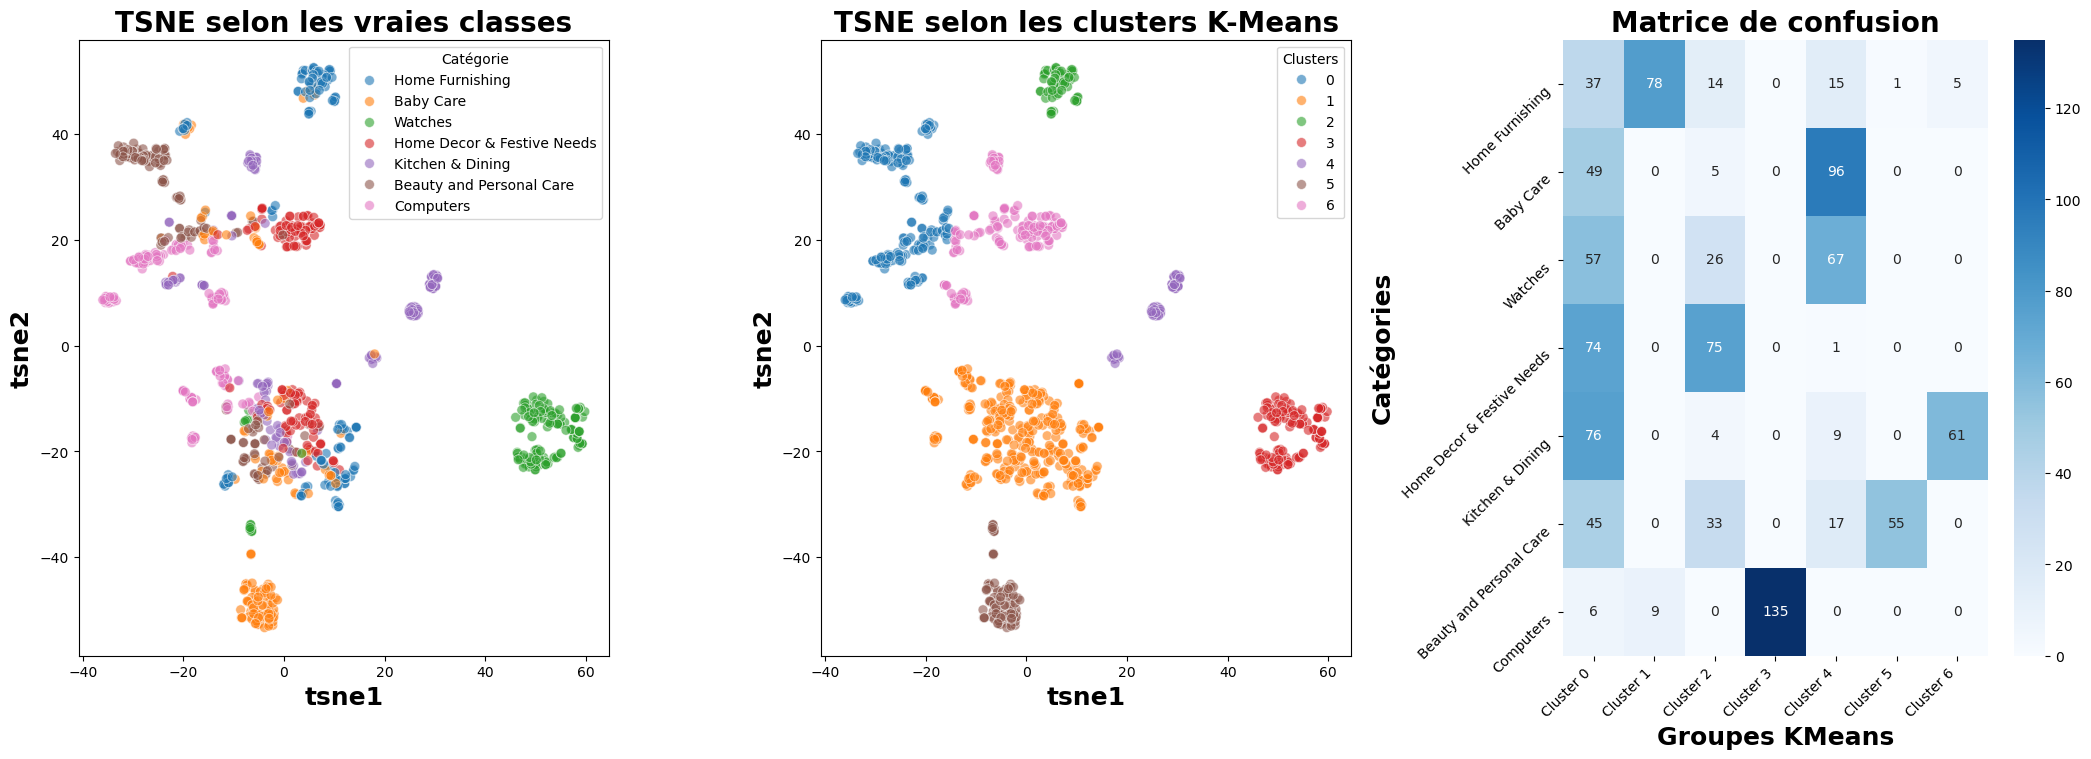

L'indice de Rand ajusté (ARI) est de 0.266.


In [168]:
# Réduction de la dimensionnalité avec t-SNE
tsne_data = reduce_dimensionality_tsne(averaged_word2vec_vectors_df)

# Appel de la fonction pour afficher les graphiques et les cluster avec K-Means
plot_tsne_and_kmeans_clusters(tsne_data)

***

# 2. Méthode BERT <a id="Méthode-BERT"></a>
L'approche **BERT (Bidirectional Encoder Representations from Transformers)** est une méthode avancée pour obtenir des représentations contextuelles de mots et de phrases. Contrairement aux modèles traditionnels comme Word2Vec, BERT prend en compte le contexte des mots dans les deux directions (avant et arrière) pour capturer des significations plus riches et plus précises.

## 2.1. Extraction des embeddings BERT

* ### **Fonctions**

In [173]:
import numpy as np
import time
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import StratifiedKFold

# Fonction de chargement du modèle et du tokenizer
def load_bert_model(model_name='bert-base-uncased'):
    """Charge le modèle et le tokenizer BERT."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModel.from_pretrained(model_name)
    return tokenizer, model

# Fonction de tokenisation des textes
def tokenize_texts(tokenizer, texts, max_length=64):
    """Tokenise les textes pour BERT en batch."""
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf',
        return_attention_mask=True,
        return_token_type_ids=True
    )

# Fonction pour extraire les embeddings BERT
def extract_bert_embeddings(model, tokenizer, texts, batch_size=10):
    """Extrait les embeddings BERT en batch pour éviter la surcharge mémoire."""
    all_embeddings = []
    start_time = time.time()
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encoded_input = tokenize_texts(tokenizer, batch_texts)
        output = model(encoded_input)[0]  # Sortie du dernier état caché
        embeddings = np.mean(output.numpy(), axis=1)  # Moyenne sur les tokens
        all_embeddings.append(embeddings)
    
    print("Temps total: {:.2f} secondes".format(time.time() - start_time))
    return np.vstack(all_embeddings)

* ### **Découpage du dataset avec StratifiedKFold (pour gérer la charge computationnelle)**

In [175]:
# Initialisation du StratifiedKFold pour diviser les données en 2 parties
stratified_kfold = StratifiedKFold(n_splits=2)

# Variables pour stocker les deux parties du DataFrame
part1_df = None
part2_df = None

# Liste pour stocker tous les embeddings extraits
all_embeddings = []

# Division des données en deux parties en utilisant StratifiedKFold
for part1_index, part2_index in stratified_kfold.split(df['cleaned_text'], df['main_category']):
    part1_df = df.loc[part1_index, :]
    part2_df = df.loc[part2_index, :]

# Affichage des distributions des classes pour chaque partie
part1_class_distribution = part1_df['main_category'].value_counts()
part2_class_distribution = part2_df['main_category'].value_counts()
print("Distribution des classes dans la première partie:")
print(part1_class_distribution)
print("\nDistribution des classes dans la deuxième partie:")
print(part2_class_distribution)

Distribution des classes dans la première partie:
main_category
Home Furnishing               75
Baby Care                     75
Watches                       75
Home Decor & Festive Needs    75
Kitchen & Dining              75
Beauty and Personal Care      75
Computers                     75
Name: count, dtype: int64

Distribution des classes dans la deuxième partie:
main_category
Kitchen & Dining              75
Home Decor & Festive Needs    75
Beauty and Personal Care      75
Computers                     75
Watches                       75
Baby Care                     75
Home Furnishing               75
Name: count, dtype: int64


**Nombre égal dans chaque catégorie.
Les classes sont bien réparties de manière égale dans les deux parties du dataframe.**

* ### **Extraction des embeddings BERT pour les descriptions**

In [178]:
# Chargement du modèle et du tokenizer BERT
tokenizer, model = load_bert_model()

# Extraction des embeddings sur les deux parties
texts_part1 = part1_df['cleaned_text'].tolist()
texts_part2 = part2_df['cleaned_text'].tolist()

# Extraction des embeddings pour chaque partie
features_bert_part1 = extract_bert_embeddings(model, tokenizer, texts_part1)
features_bert_part2 = extract_bert_embeddings(model, tokenizer, texts_part2)

# Ajout des embeddings des deux sous-ensembles à la liste
all_embeddings.append(features_bert_part1)
all_embeddings.append(features_bert_part2)

#***************
# Concaténation des embeddings des deux parties pour obtenir un tableau final
final_embeddings = np.vstack(all_embeddings)

# Sauvegarde des embeddings dans un fichier pour un usage ultérieur (Optionnel)
np.save("final_features_bert.npy", final_embeddings)

# Affichage des dimensions finales des embeddings
print("Dimensions des embeddings extraits:", final_embeddings.shape)

#****************

# OU
# Si l'on veut les concaténer plus tard :
#all_features_bert = np.vstack([features_bert_part1, features_bert_part2])

# On peut aussi sauvegarder chaque partie séparément (Optionnel)
#np.save("features_bert_part1.npy", features_bert_part1)
#np.save("features_bert_part2.npy", features_bert_part2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Temps total: 80.80 secondes
Temps total: 75.01 secondes
Dimensions des embeddings extraits: (1050, 768)


* **C'est un bon résultat !** Le fait qu'on ait extrait des embeddings BERT en 82.88 secondes et 78.03 secondes pour chaque partie et que les dimensions finales des embeddings soient (1050, 768) montre que tout s'est bien passé.

* **Analyse des résultats :** Temps total : Le temps total de traitement pour chaque sous-ensemble semble raisonnable, compte tenu de la taille du dataset et de la puissance de calcul disponible.

* **Dimensions des embeddings :** Les dimensions (1050, 768) correspondent à un ensemble de 1050 échantillons avec des embeddings de 768 dimensions, ce qui est la taille typique pour les sorties de BERT.

## 2.2. Réduction dimensionnelle avec PCA & Visualisation avec t-SNE + Clustering K-Means

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


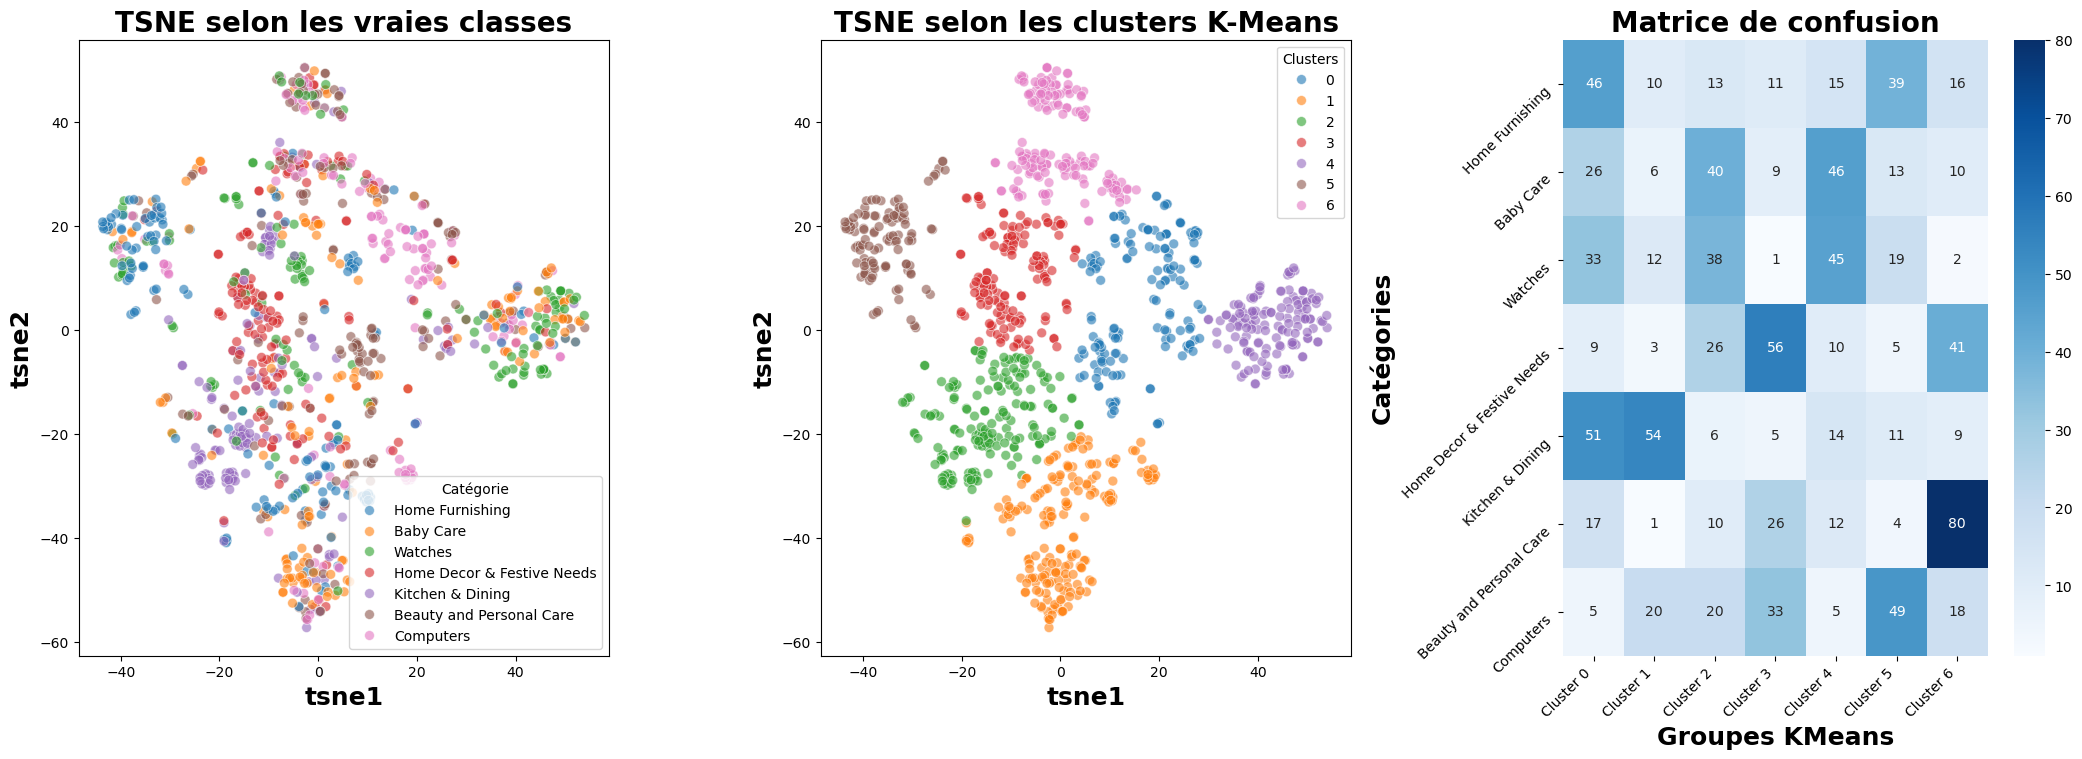

L'indice de Rand ajusté (ARI) est de 0.107.


In [181]:
# Réduction des dimensions avec PCA
flattened_data = pd.DataFrame(final_embeddings) #transformation de final_embeddings (tableau NumPy) en DataFrame Pandas, plus pratique pour le traitement ensuite.


# Application de PCA pour réduire les dimensions tout en conservant 99% de la variance
pca_reduced_data = reduce_dimensionality_pca(flattened_data, 0.99) 
#On applique le PCA pour réduire la dimension des embeddings en gardant 99 % de la variance (information).
#Avantages : Moins de bruit - Moins de dimensions (t-SNE sera plus rapide et plus stable) - Conservation de l’essentiel de la structure globale des données.


# Application de t-SNE pour une visualisation en 2D
tsne_transformed_data = reduce_dimensionality_tsne(pca_reduced_data)
#t-SNE n'est pas fait pour le clustering, mais pour explorer visuellement la distribution des points. 
#Il déforme volontairement les distances pour révéler des regroupements locaux.


# Affichage des graphiques des clusters et calcul du score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_data)


**Pourquoi avons nous appliqué PCA avant t-SNE ?**

* **Denoising :** PCA élimine du bruit en compressant les infos dans moins de dimensions. Cela aide t-SNE à mieux capturer la structure locale des données, et à mieux travailler sur des données déjà débruitées et "positionnées".
* **Gain de temps :** t-SNE est très lent sur des matrices larges. Réduire d’abord avec PCA rend le t-SNE bien plus rapide, permet de gagner beaucoup de temps, surtout sur des matrices TF-IDF ou des embeddings d’images.
* **Stabilité :** t-SNE est très sensible aux variations — un prétraitement PCA rend les résultats plus stables.

**Donc, PCA est une étape de "pré-nettoyage" avant t-SNE.**
***
**Alors pourquoi ne pas visualiser PCA directement ?**
* PCA préserve la variance globale mais pas forcément la structure locale (groupes similaires proches).
* t-SNE, lui, est excellente pour visualiser les structures locales : c’est ce que l'on veut pour voir les clusters.

**Donc :**
* PCA = bon pour compresser
* t-SNE = bon pour réduire à 2D et visualiser proprement

***

# 3. Méthode USE (Universal Sentence Encoder) <a id="Méthode-USE"></a>
L'approche **USE (Universal Sentence Encoder)** est une méthode avancée pour obtenir des représentations vectorielles de phrases et de textes. Développé par Google, USE produit des embeddings de haute qualité pour des phrases entières plutôt que des mots individuels. Il est particulièrement utile pour des tâches telles que la classification de texte, la similarité de texte et le clustering de texte.

## 3.1. Extraction des embeddings USE 
* Chargement du modèle pré-entraîné USE
* Extraction des embeddings pour les descriptions)

In [187]:
import tensorflow_hub as hub
import pandas as pd

# Chargement du modèle Universal Sentence Encoder depuis TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Application de l'encodage USE à la colonne 'cleaned_text'
sentences = df['cleaned_text'].tolist()
embeddings = use_model(sentences)

# Conversion des embeddings en DataFrame pour une analyse ultérieure
embeddings_df = pd.DataFrame(embeddings.numpy())

# Affichage des dimensions des embeddings
print("Dimensions des embeddings USE:", embeddings_df.shape)

# Affichage du DataFrame résultant
embeddings_df

# Sauvegarde des embeddings dans un fichier CSV
embeddings_df.to_csv("VariablesUSE.csv", index=False)

Dimensions des embeddings USE: (1050, 512)


## 3.2. Réduction dimensionnelle avec PCA & Visualisation avec t-SNE + Clustering K-Means

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


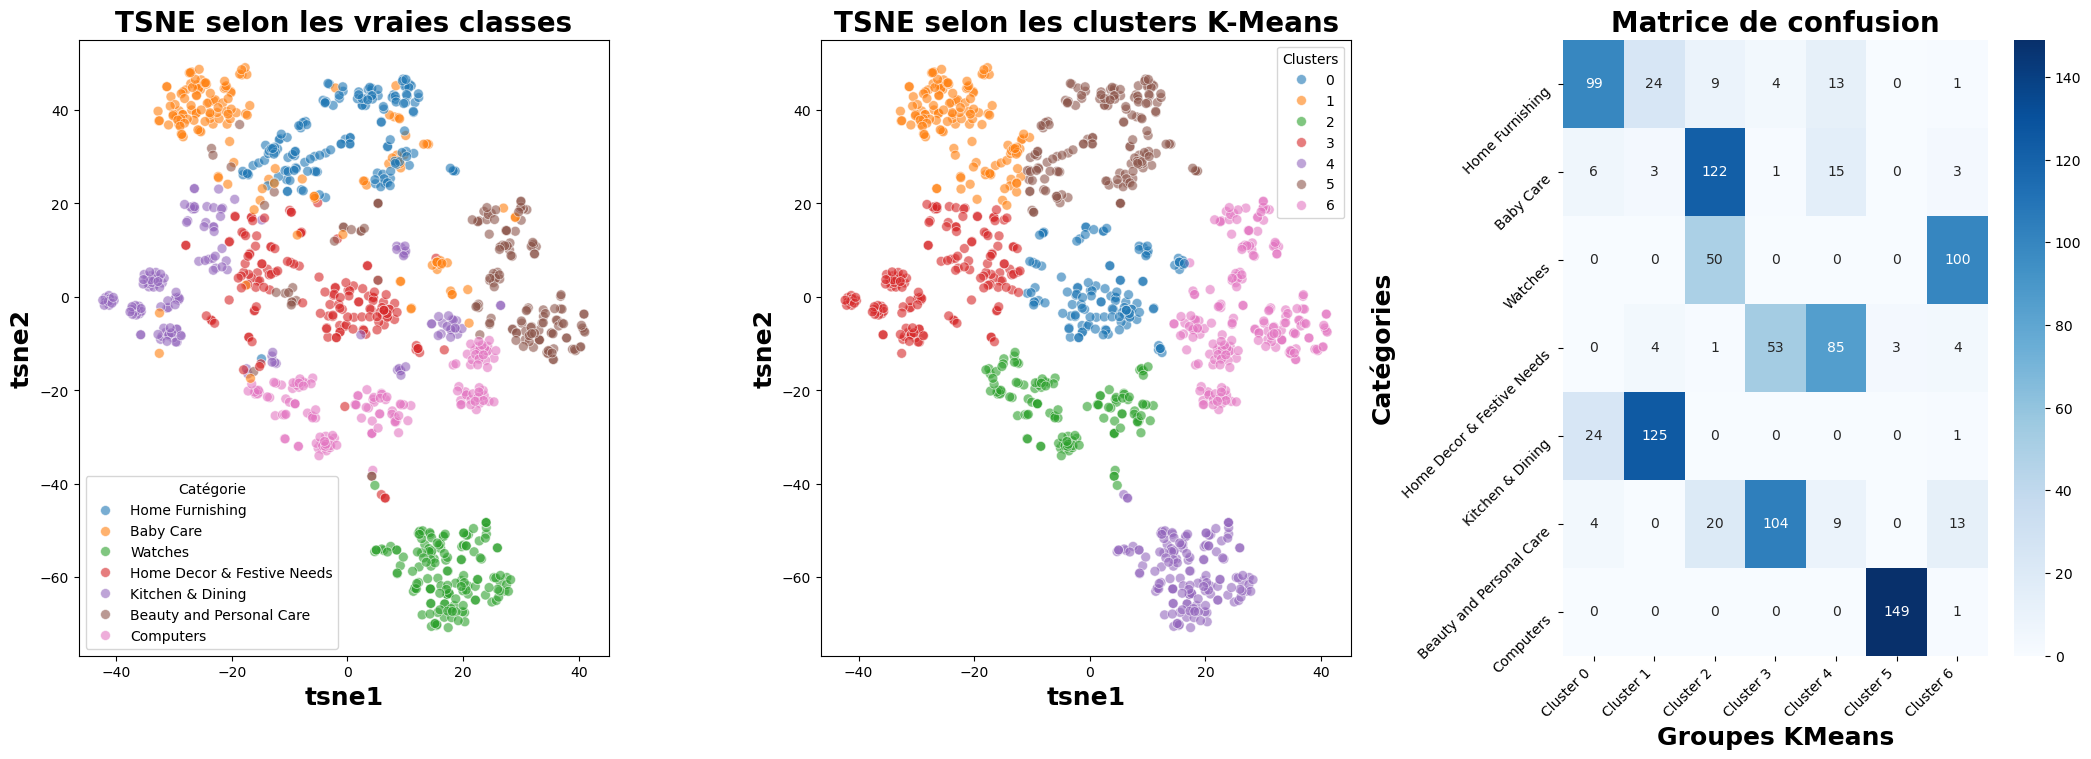

L'indice de Rand ajusté (ARI) est de 0.547.


In [190]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Réduction des dimensions avec PCA
# Application de PCA pour réduire les dimensions tout en conservant 99% de la variance
pca_reduced_embeddings = reduce_dimensionality_pca(embeddings_df, 0.99)

# Application de t-SNE pour une visualisation en 2D
tsne_transformed_embeddings = reduce_dimensionality_tsne(pca_reduced_embeddings)

# Affichage des graphiques des clusters et calcul du score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_embeddings)

# __________________________________________________________________________________________

# **ETAPE 3 :** L’Etat de l’art <a id="L’Etat-de-l’art"></a>

# 1. Méthode DeBERTa <a id="Méthode-DeBERTa"></a>

### **1.1. Utilisation de DeBERTa avec un Modèle de base (deberta-base).**
* **DeBERTa-base** : Un modèle DeBERTa plus petit avec environ 110 millions de paramètres. Il possède 12 couches de transformateurs, 12 têtes d'attention, et une taille d'embedding de 768. Ce modèle est moins gourmand en ressources, plus rapide à entraîner et à utiliser, mais offre des performances légèrement inférieures par rapport à DeBERTa-large, particulièrement adapté pour des tâches NLP standard et des environnements avec des ressources limitées.

In [242]:
import time
from transformers import AutoTokenizer, TFAutoModel

def extraire_caracteristiques_textuelles_avec_deberta(df):
    """
    Extraire les caractéristiques textuelles en utilisant le modèle DeBERTa.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant une colonne 'cleaned_text' avec des données textuelles.

    Retourne:
    np.ndarray: Caractéristiques extraites du modèle DeBERTa.
    """
    
    # Extraction des phrases du DataFrame
    phrases = df['cleaned_text'].values.tolist()
    taille_lot = 10  # Taille du batch
    longueur_max = 64  # Longueur maximale des séquences
    nom_modele = 'microsoft/deberta-base'  # Type de modèle DeBERTa
    
    # Chargement du tokenizer et du modèle DeBERTa
    tokenizer = AutoTokenizer.from_pretrained(nom_modele)
    modele = TFAutoModel.from_pretrained(nom_modele)
    
    # Enregistrement du temps de début
    debut_temps = time.time()

    # Traitement des phrases par lots
    for etape in range(len(phrases) // taille_lot):
        idx_debut_lot = etape * taille_lot
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        # Tokenisation des phrases dans le lot
        for phrase in phrases[idx_debut_lot:idx_debut_lot + taille_lot]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)
        
        # Création d'un dictionnaire avec les textes prétraités
        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }
        
        # Obtention des sorties du modèle DeBERTa
        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]
             
        if etape == 0:
            tous_etats_caches = derniers_etats_caches
        else:
            tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)
    
    # Calcul de la moyenne des derniers états cachés
    caracteristiques_deberta = np.mean(tous_etats_caches, axis=1)
    
    # Enregistrement du temps de fin et calcul du temps écoulé
    fin_temps = np.round(time.time() - debut_temps, 0)
    print("Temps de traitement : ", fin_temps, "secondes")
    
    return caracteristiques_deberta

### a) Extraction des embeddings DeBERTa (deberta-base) <a id="Extraction-des-embeddings-DeBERTa"></a>

In [245]:
# Extraction des caractéristiques avec DeBERTa
features_deberta = extraire_caracteristiques_textuelles_avec_deberta(df)

# Affichage de la forme des arrays
print(features_deberta.shape)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

C:\Users\matym\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\matym\.cache\huggingface\hub\models--microsoft--deberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Temps de traitement :  336.0 secondes
(1050, 768)


### b) Réduction dimensionnelle avec PCA & Visualisation avec t-SNE + Clustering K-Means

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


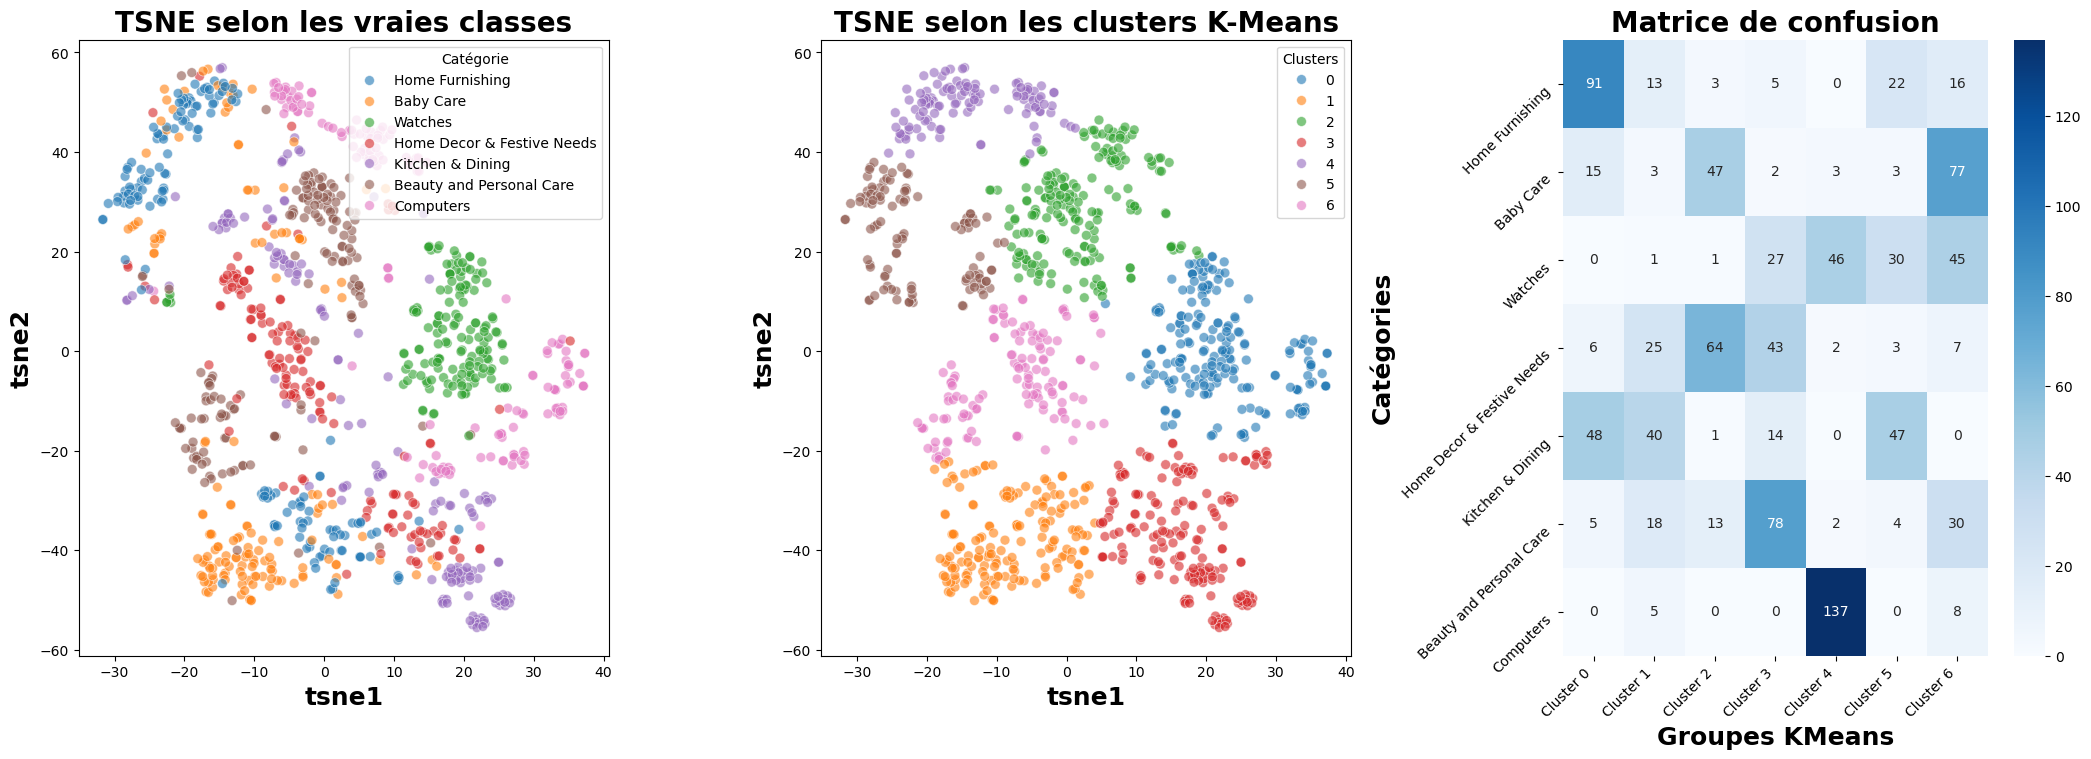

L'indice de Rand ajusté (ARI) est de 0.281.


In [248]:
# Réduction des dimensions avec PCA
flattened_data_deberta = pd.DataFrame(features_deberta.reshape(1050, 768))
pca_reduced_data_deberta = reduce_dimensionality_pca(flattened_data_deberta, 0.99)

# Application de t-SNE pour une visualisation en 2D
tsne_transformed_data_deberta = reduce_dimensionality_tsne(pca_reduced_data_deberta)
#t-SNE n'est pas fait pour le clustering, mais pour explorer visuellement la distribution des points. 
#Il déforme volontairement les distances pour révéler des regroupements locaux.

# Affichage des graphiques des clusters et calculer le score ARI
plot_tsne_and_kmeans_clusters(tsne_transformed_data_deberta)

***

### **1.2. Utilisation de DeBERTa avec un Modèle Plus Grand**
* Nous allons essayer le modèle DeBERTa-large pour voir si cela améliore les performances

**DeBERTa-large** : 
* Une version plus grande de DeBERTa avec environ 340 millions de paramètres.
* Il dispose de 24 couches de transformateurs, 16 têtes d'attention, et une taille d'embedding de 1024.
* Ce modèle est plus performant pour des tâches NLP complexes, offrant une meilleure capacité de modélisation des relations sémantiques, mais nécessite davantage de ressources computationnelles et de temps d'entraînement.
* Il est idéal pour des tâches où la précision est cruciale.

In [274]:
import time
from transformers import AutoTokenizer, TFAutoModel

def extraire_caracteristiques_textuelles_avec_deberta(df, modele_nom='microsoft/deberta-large', taille_lot=10, longueur_max=64):
    """
    Extraire les caractéristiques textuelles en utilisant le modèle DeBERTa.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant une colonne 'cleaned_text' avec des données textuelles.
    modele_nom (str): Le modèle DeBERTa à utiliser ('microsoft/deberta-base' ou 'microsoft/deberta-large').
    taille_lot (int): Taille des lots à utiliser pour le traitement.
    longueur_max (int): Longueur maximale des séquences.

    Retourne:
    np.ndarray: Caractéristiques extraites du modèle DeBERTa.
    """
    
    # Extraction des phrases du DataFrame
    phrases = df['cleaned_text'].values.tolist()
    
    # Chargement du tokenizer et du modèle DeBERTa
    tokenizer = AutoTokenizer.from_pretrained(modele_nom)
    modele = TFAutoModel.from_pretrained(modele_nom)
    
    # Enregistrement du temps de début
    debut_temps = time.time()

    # Traitement des phrases par lots
    for etape in range(len(phrases) // taille_lot):
        idx_debut_lot = etape * taille_lot
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        # Tokenisation des phrases dans le lot
        for phrase in phrases[idx_debut_lot:idx_debut_lot + taille_lot]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)
        
        # Création d'un dictionnaire avec les textes prétraités
        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }
        
        # Obtention des sorties du modèle DeBERTa
        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]
             
        if etape == 0:
            tous_etats_caches = derniers_etats_caches
        else:
            tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)
    
    # Traitement du dernier lot incomplet s'il reste des phrases
    reste = len(phrases) % taille_lot
    if reste > 0:
        idx_debut_lot = len(phrases) - reste
        
        ids_entree = []
        ids_type_token = []
        masques_attention = []

        for phrase in phrases[idx_debut_lot:]:
            entree_encodee = tokenizer.encode_plus(
                phrase,
                add_special_tokens=True,
                max_length=longueur_max,
                padding='max_length',
                return_attention_mask=True, 
                return_token_type_ids=True,
                truncation=True,
                return_tensors='tf'
            )

            ids_entree.append(entree_encodee['input_ids'][0])
            ids_type_token.append(entree_encodee['token_type_ids'][0])
            masques_attention.append(entree_encodee['attention_mask'][0])

        ids_entree = np.asarray(ids_entree)
        ids_type_token = np.asarray(ids_type_token)
        masques_attention = np.asarray(masques_attention)

        texte_pretraite = {
            "input_ids": ids_entree, 
            "attention_mask": masques_attention, 
            "token_type_ids": ids_type_token
        }

        sorties_modele = modele(texte_pretraite)
        derniers_etats_caches = sorties_modele[0]

        tous_etats_caches = np.concatenate((tous_etats_caches, derniers_etats_caches), axis=0)

    # Moyenne des états cachés par phrase
    caracteristiques_deberta = np.mean(tous_etats_caches, axis=1)

    # Enregistrement du temps de fin et calcul du temps écoulé
    fin_temps = np.round(time.time() - debut_temps, 0)
    print("Temps de traitement : ", fin_temps, "secondes")
    
    
    return caracteristiques_deberta

### a) Extraction des embeddings DeBERTa (deberta-large) - (avec Ajustement des Hyperparamètres) <a id="Extraction-des-embeddings-DeBERTa-(deberta-large)"></a>

* Pour ajuster les hyperparamètres tels que la longueur maximale des séquences (max_length) ou la taille des lots (batch_size), nous pouvons simplement modifier les valeurs lors de l'appel à la fonction.

In [277]:
# Extraction des caractéristiques avec DeBERTa avec des hyperparamètres ajustés
features_deberta_ = extraire_caracteristiques_textuelles_avec_deberta(
    df, 
    modele_nom='microsoft/deberta-large', 
    taille_lot=16,  # Augmentation de la taille des lots
    longueur_max=128  # Augmentation de la longueur maximale des séquences
)

# Affichage de la forme des arrays
print(features_deberta_.shape)

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


Temps de traitement :  1003.0 secondes
(1050, 1024)


### b) Réduction dimensionnelle avec PCA & Visualisation avec t-SNE + Clustering K-Means

* Une fois les caractéristiques extraites avec DeBERTa, réutilisons les fonctions existantes pour réduire la dimensionnalité avec PCA et t-SNE, puis visualisons et évaluons les clusters :

In [279]:
def plot_tsne_and_kmeans_clusters_deberta(tsne_data, df):
    
    """
    Affiche des graphiques 2D des clusters t-SNE réels et KMeans, et crée une matrice de confusion.

    Paramètres:
    tsne_data (ndarray): Données transformées par t-SNE.

    Retourne:
    None
    """
    # Création d'un DataFrame à partir des résultats t-SNE
    df_tsne = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
    df_tsne['class'] = df['main_category']

    # Définition des catégories pour la légende
    categories = df['main_category'].unique()
    category_palette = sns.color_palette('tab10', len(categories))

    # Agrandissement de la figure
    plt.figure(figsize=(26, 8))

    # Affichage des vraies classes
    plt.subplot(131)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='class', palette=category_palette, s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les vraies classes', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Catégorie', prop={'size': 10})

    # Clustering avec K-Means
    kmeans = cluster.KMeans(n_clusters=7, n_init=100)
    kmeans.fit(tsne_data)
    df_tsne['cluster'] = kmeans.labels_

    # Affichage des clusters K-Means
    plt.subplot(132)
    sns.scatterplot(
        x='tsne1', y='tsne2', hue='cluster',
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne, legend='brief'
    )
    plt.title('TSNE selon les clusters K-Means', fontsize=20, fontweight='bold')
    plt.xlabel('tsne1', fontsize=18, fontweight='bold')
    plt.ylabel('tsne2', fontsize=18, fontweight='bold')
    plt.legend(title='Clusters', prop={'size': 10})

    # Matrice de confusion
    labels = df['main_category'].astype(str)  
    kmeans_labels = kmeans.labels_.astype(str) 

    # Création d'un dictionnaire pour relier chaque label KMeans à la catégorie réelle
    label_to_cluster = {i: label for i, label in enumerate(categories)}

    # Remappage des labels KMeans aux catégories réelles
    mapped_kmeans_labels = [label_to_cluster[int(cluster)] for cluster in kmeans_labels]

    # Calcul de la matrice de confusion
    conf_mat = metrics.confusion_matrix(labels, mapped_kmeans_labels)
    df_cm = pd.DataFrame(conf_mat, index=categories, columns=[f'Cluster {i}' for i in range(7)])

    # Affichage de la matrice de confusion
    plt.subplot(133)
    plt.title('Matrice de confusion', size=20, fontweight='bold')
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
    # Inclinaison des étiquettes de l'axe X et Y
    plt.xticks(rotation=45, ha='right')  # Inclinaison des labels de l'axe X
    plt.yticks(rotation=45, va='top')  # Inclinaison des labels de l'axe Y
    plt.xlabel('Groupes KMeans', fontsize=18, fontweight='bold')
    plt.ylabel('Catégories', fontsize=18, fontweight='bold')

    # Ajustement de l'espacement entre les sous-graphes pour éviter qu'ils ne se chevauchent
    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Augmentation de l'espacement horizontal et vertical
    
    plt.show()

    
    # Affichage de l'ARI
    ari = round(metrics.adjusted_rand_score(labels, kmeans.labels_), 3)
    print(f"L'indice de Rand ajusté (ARI) est de {ari}.")

C:\Users\matym\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\matym\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


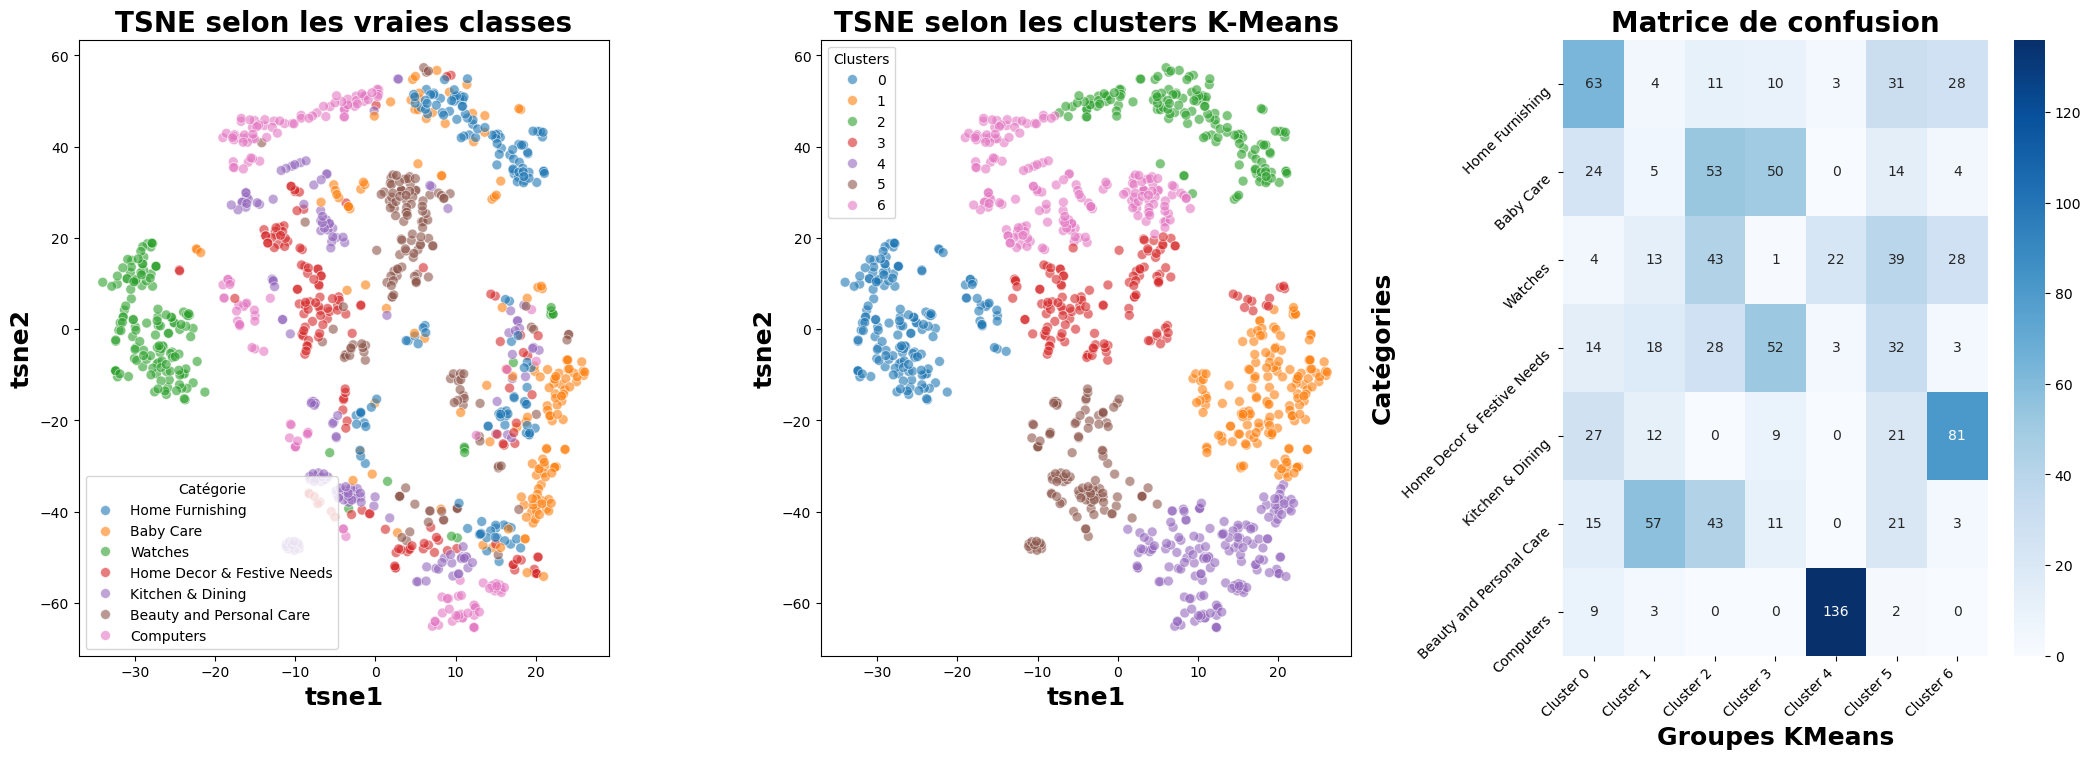

L'indice de Rand ajusté (ARI) est de 0.227.


In [281]:
# Réduction des dimensions avec PCA
flattened_data_deberta = pd.DataFrame(features_deberta_.reshape(features_deberta_.shape[0], -1))
pca_reduced_data_deberta = reduce_dimensionality_pca(flattened_data_deberta, 0.99)

# Application de t-SNE pour une visualisation en 2D
tsne_transformed_data_deberta = reduce_dimensionality_tsne(pca_reduced_data_deberta)

# Exécution de la fonction avec DeBERTa
plot_tsne_and_kmeans_clusters_deberta(tsne_transformed_data_deberta, df)

### **Explication avec SHAP (global et local)**

Accuracy of the model: 0.9428571428571428


C:\Users\matym\anaconda3\Lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


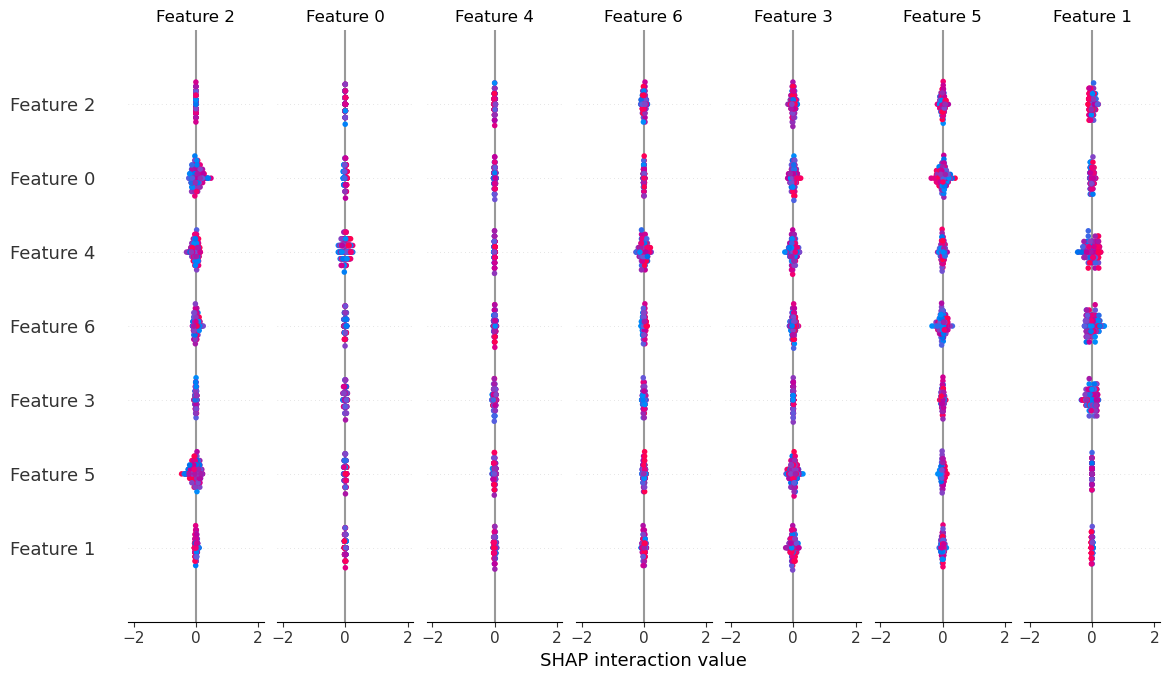

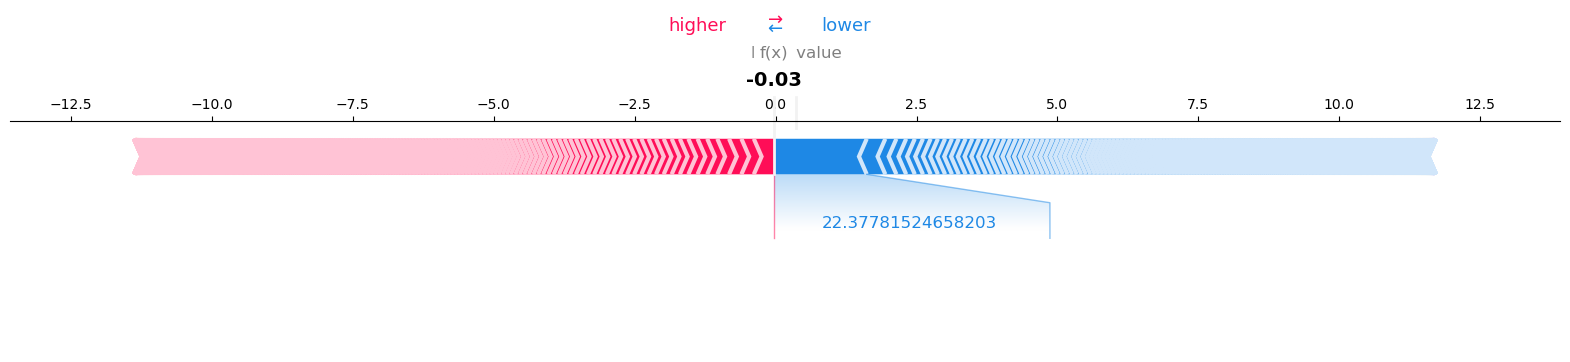

In [291]:
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Étape 1 : Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_deberta, df['main_category'], test_size=0.2, random_state=42)

# Étape 2 : Entraînement d'un modèle de régression logistique
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Étape 3 : Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

# ---- SHAP ----
# Étape 4 : Explication globale avec SHAP
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Graphique SHAP Summary (importance globale des caractéristiques)
shap.summary_plot(shap_values, X_test)

# Étape 5 : Explication locale avec SHAP (pour un exemple spécifique)

# Conversion des valeurs SHAP en float64 pour éviter les erreurs de JSON
shap_values_for_output = shap_values[..., output_index].astype(np.float64)  # Conversion en float64
X_test_float64 = X_test.astype(np.float64)

# Affichage de l'explication locale avec shap.plots.force après la conversion
# X_test_float64 est un np.ndarray, donc accès par index standard
shap.plots.force(base_value, shap_values_for_output[0], X_test_float64[0], matplotlib=True)

**1. Graphique SHAP Summary Plot (Importance globale des caractéristiques) :**

Ce graphique montre l'importance globale des interactions entre les caractéristiques dans les prédictions du modèle.

* Explication générale : Les points représentent des valeurs SHAP pour chaque caractéristique, et chaque colonne représente une caractéristique. Les points roses indiquent les valeurs élevées de la caractéristique, tandis que les points bleus montrent les valeurs faibles.
* Interprétation :
    * Les features 2, 4 et 6 montrent une forte variabilité d’impact, ce qui indique qu’elles sont influentes mais contextuelles.
Un impact centré près de zéro reflète une faible contribution moyenne.
***
**2. Graphique SHAP Force Plot (Explication locale) :**

Ce graphique montre comment chaque caractéristique influence une prédiction spécifique.

* Interprétation :
    * Les flèches roses indiquent les caractéristiques qui augmentent la prédiction vers des valeurs plus élevées (valeurs positives), et les flèches bleues montrent celles qui poussent la prédiction vers des valeurs plus basses.
    * Interprétation du modèle : Dans cet exemple spécifique, le modèle est fortement influencé par certaines caractéristiques qui réduisent la prédiction (flèches bleues), et d’autres qui l’augmentent (flèches rouges), ce qui donne une prédiction ajustée.

### **Explication avec LIME (local)**

In [295]:
import numpy as np

# s'assurer que X_train et X_test sont des numpy arrays
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

feature_names = [f'feature_{i}' for i in range(X_train_np.shape[1])]

# Classes cibles
class_names = df['main_category'].unique().tolist()

# ---- LIME ---- Explication locale avec LIME
# Création de l'explainer LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    verbose=True,
    mode='classification'
)

# Explication LIME pour un exemple spécifique
lime_instance = lime_explainer.explain_instance(
    X_test_np[0],   # numpy array de la première instance
    model.predict_proba  # fonction prédictive probabiliste
)

# Affichage dans notebook (ou Jupyter)
lime_instance.show_in_notebook(show_table=True)

# Sinon sauvegarde dans un fichier HTML
# lime_instance.save_to_file('lime_explanation.html')

Intercept 0.2931507107494111
Prediction_local [0.11548553]
Right: 0.024314777922822196


**3. Graphique LIME (Explication locale des probabilités) :**

Ce graphique montre comment LIME décompose une prédiction locale en termes de probabilités de classe et caractéristiques influentes.

* Prédiction locale : La classe prédite est "Watches" avec une probabilité de 0.89. Cela signifie que le modèle est confiant que cet exemple appartient à la catégorie "Watches".
* Interprétation des caractéristiques :
    * Les barres horizontales indiquent l'effet de chaque feature sur la classification :
  
        🟧 Vers "Baby Care",
      
        🟦 Vers "NOT Baby Care" (ici : « Watches »).

* À droite, les valeurs réelles des features sont colorées selon leur orientation.

**En résumé :**
* Le SHAP Summary Plot donne une vue d'ensemble des caractéristiques les plus influentes dans les prédictions du modèle.
* Le SHAP Force Plot montre comment les caractéristiques individuelles affectent une prédiction spécifique.
* Le graphique LIME aide à comprendre localement pourquoi le modèle a choisi une certaine classe pour un exemple donné, en décomposant les probabilités de prédiction.

***